In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import markdown
import sys
sys.path.append('/Users/vs522/Dropbox/Python')
from astropy.table import Table
from astropy import units as u
import seaborn as sns
import os
import glob
import linecache
import re
from IPython.display import Image
import itertools
import reddening_laws as red
from astropy.stats import sigma_clip
import scipy.optimize as op
from astroquery.irsa_dust import IrsaDust
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord





bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

sns.set_palette("Set2")
colours = sns.color_palette()

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# RR Lyrae PLZ relation for use in SMHASH papers prior to Gaia DR2

* Working on RR Lyrae PLZ relation for use in SMHASH papers prior to Gaia DR2
* Current Gaia DR1 results are not good enough to derive an RRL PLZ relation that is *better than* that acheiveable from globular clusters and HST parallaxes.
* Need to wait for Gaia DR2 for full parallax solutions and consistent metallicities.
* Until then, using the following data:

1) M4 slope using updated photometry from Neeley -- ** important - need to know which reference to use here - is Neeley PhD thesis correct, or is there a paper in prep we can refer to? **

2) Metallcicities compiled by Beaton/Monson (Monson/Beaton/Scowcroft 2017 paper?) for Galactic Cepheids

3) Spitzer photometry from Scowcroft (which will be published in full in this paper).

### Neeley et al. PL relations from updated Spitzer photometry: [Link to google doc](https://docs.google.com/document/d/1u3MIKCe7GI8dsjDiEmUxmcDWLuy0oaILutW_vm2yZaE/edit)

* RRab only
$$ M_{[3.6]} = -2.342 \pm 0.140 \log P -1.155 \pm 0.089, \sigma = 0.130 $$

$$ M_{[4.5]}= -2.358 \pm 0.165 \log P -1.170 \pm 0.089, \sigma = 0.127 $$ 

* RRab + RRc (fundamentalized)
$$ M_{[3.6]} = -2.304 \pm 0.105 \log P -1.112 \pm 0.079, \sigma = 0.128 $$
$$ M_{[4.5]}= -2.340 \pm 0.104 \log P -1.139 \pm 0.079, \sigma = 0.125 $$

* Usage notes: 
  * When using a sample of *only* RRab stars, use the RRab only PL relations
  * When using a sample of RRab and RRc stars use the RRab + RRc (fundamentalized)
  * RRc stars are not yet well characterized enough (i.e. we don't have enough RRc stars) to look at RRc only PL relations.



### Grabbing RR Lyrae data from Monson et al. (2017) table 1 

In [2]:
## function to grab extinctio from IRSA dust service, add it to the data frame
def grab_extinction(row):
    star_name = row.Name
    print(star_name)
    result_table = Simbad.query_object(star_name)
    result_df = result_table.to_pandas()
    ra = result_df.RA.values[0]
    dec = result_df.DEC.values[0]
    print((ra, dec))
    table = IrsaDust.get_extinction_table(SkyCoord(ra, dec, frame='icrs', unit=(u.hour, u.deg)))
    irac_1_sandf = table[19][3]
    irac_2_sandf = table[20][3]
    rrl_df.ix[rrl_df.Name==star_name, 'A_3p6'] = float(irac_1_sandf)
    rrl_df.ix[rrl_df.Name==star_name, 'A_4p5'] = float(irac_2_sandf)
    print((star_name, irac_1_sandf, irac_2_sandf))
    return(0)
 

# DO NOT RUN CELL BELOW UNLESS REREADING DATA FROM SCRATCH

# HST parallax subset

* Benedict HST parallax subset (using values published in Neeley et al (2015) as these are corrected for typos's in Benedict:
  * RZ Cep: E(B-V) = 0.252, $\varpi = 2.54 \pm 0.19$
  * XZ Cyg: E(B-V) = 0.100  $\varpi = 1.67 \pm 0.17$
  * UV Oct: E(B-V) = 0.090  $\varpi = 1.71 \pm 0.10$
  * RR Lyr: E(B-V) = 0.042  $\varpi = 3.77 \pm 0.13$
  * SU Dra: E(B-V) = 0.010  $\varpi = 1.42 \pm 0.16$
* Not using the LKH correction (see arguments in various Monson papers/emails etc as to why it's not appropriate for this sample.

# How to get the PLZ from the big sample?

## Test one:

* Have calibrated PL relation using the HST sample and M4 slopes.
* Have apparent mags, [Fe/H] and can get extinctions for all of the sample from IRSA.


1. Grab extinctions for everything and get extinction corrected apparent mags
2. Derive PLZ using the 4 star RRab-only HST sample.
3. Apply this to the whole RRab-only sample to derive what their distances would be from the PLZ
4. Compare to Gaia DR1 parallaxes where available



### Change in print syntax for python 3!
* have to use parens for print! Can't just use sloppy `print $var` syntax in python 3

### Quick check: 
* How different are the $A_{[3.6]}$ from IRSA from the ones in Neeley et al for the 5 calibrators?
* All RRab $A_{[3.6]}$ agree between Neeley et al (2015) (which come from Benedict et al) and IRSA measurements to better than 0.01 mag. 
* RZ Cep (which is an RRc) is significantly different:
  * $A_{[3.6]}$ Neeley = 0.051, IRSA = 0.187
  * $A_{[4.5]}$ Neeley = 0.039, IRSA = 0.155
* Sticking with the RRab only right now, but bear this in mind.

### Going forward: 
* Using the IRSA dust map measurements
* These come from the Schlafly & Finkbeiner (2011) dust map
* Chosen these as they can be applied to any star - i.e. not just those in Monson et al., but will be applicable to target stars in streams.



In [3]:
#rrl_df.rename(columns={' HJD_max': 'HJD_max'}, inplace=True) ## messed up a column name. Fixed it upstream too now

In [4]:
#rrl_df.to_csv('rrl_df')


In [5]:
rrl_df = pd.read_csv('rrl_df', index_col=0)
rrl_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       xxand    9.409    0.009    9.384    0.008  0.722757  2456751.00   
2       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
3        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
4       aeboo    9.750    0.011    9.749    0.011  0.314890  2456750.50   
5       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
6       tvboo   10.197    0.009   10.179    0.009  0.312561  2456750.00   
7       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
8       stcvn   10.437    0.009   10.413    0.009  0.329045  2456750.50   
9       uycam   10.778    0.009   10.763    0.009  0.267027  2456750.25   
10      yzcap   10.337    0.009   10.321    0.009  0.273456  2456750.50   
11      rzcep    7.871    0.008    7.858    0.009  0.308680  2456755.25   
12      rrcet    8.501    0.009    8.489    0.008  0.553029  2456750.25   
13      rvcrb   10.493    0.008   10.470    0.009  0.331680  2456750.50   
14       wcrt   10.506    0.011   10.500    0.011  0.412015  2456750.25   
15      uycyg    9.709    0.009    9.688    0.008  0.560705  2456750.50   
16      xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
17      dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
18      sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
19      swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
20      cseri    8.125    0.008    8.109    0.009  0.311331  2456750.50   
21      rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
22      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
23      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
24      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
25      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
26      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
27       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
28      bxleo   10.678    0.009   10.670    0.009  0.362755  2456750.75   
29      rrleo    9.658    0.008    9.630    0.008  0.452393  2456750.75   
30      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
31      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
32      rvoct    9.492    0.011    9.480    0.011  0.571163  2456750.50   
33      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
34      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
35      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
36      dhpeg    8.594    0.009    8.600    0.009  0.255511  2456553.00   
37      rupsc    9.088    0.009    9.075    0.008  0.390365  2456750.25   
38      bbpup   10.875    0.011   10.873    0.011  0.480549  2456750.00   
39      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
40      ruscl    9.172    0.009    9.148    0.009  0.493355  2456750.25   
41      svscl   10.506    0.009   10.502    0.009  0.377356  2457000.50   
42      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
43      apser   10.212    0.008   10.202    0.009  0.340830  2456750.50   
44       tsex    9.141    0.009    9.119    0.008  0.324685  2456750.25   
45   v0440sgr    9.038    0.009    9.022    0.008  0.477479  2456750.75   
46   v0675sgr    8.954    0.009    8.929    0.009  0.642289  2456750.75   
47      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
48      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
49      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
50      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H       Name  A_3p6  A_4p5  M_abs_3p6  M_abs_4p5 calibrator  \
0      RRab -0.24     S

### uncertainty on extinction

* Read Schafly & Finkbeiner (2011) 
* **Very** conservative estimate for uncertainty on A_3p6 is 3% fractional uncertainty.
* Clarifying what A_3p6 is: Assumes Rv = 3.1, uses S&F 2011 extinction maps from SDSS.

In [6]:
rrl_df['e_A_3p6'] = rrl_df.apply(lambda x: x.A_3p6*0.03, axis=1)
rrl_df['e_A_4p5'] = rrl_df.apply(lambda x: x.A_4p5*0.03, axis=1)


In [7]:
### Get absolute mags of stars

## M_abs_3p6 = mag_3p6 - A_3p6

rrl_df['M_abs_3p6'] = rrl_df.apply(lambda x: (x.mag_3p6 - x.A_3p6), axis=1)
rrl_df['M_abs_4p5'] = rrl_df.apply(lambda x: (x.mag_4p5 - x.A_4p5), axis=1)


### OK, now we have all the info we need. Abs mags, periods, [Fe/H]. Should be able to fit this thing.

In [8]:
rrl_df['calibrator'] = False
rrl_df.ix[11, 'calibrator'] = True ## RZ Cep
rrl_df.ix[16, 'calibrator'] = True ## XZ Cyg
rrl_df.ix[33, 'calibrator'] = True ## UV Oct
rrl_df.ix[31, 'calibrator'] = True ## RR Lyr
rrl_df.ix[18, 'calibrator'] = True ## SU Dra

#ab_df = analysis_df.where(analysis_df.Type=='ab').dropna(axis=0, how='all')

rrl_df['logP'] = rrl_df.apply(lambda x: np.log10(x.P_final), axis=1)

rrab_df = rrl_df.where(rrl_df.RRL_type=='RRab').dropna(axis=0,how='all') ## whole RRab sample
rrab_cal_df = rrab_df.where(rrab_df.calibrator==1).dropna(axis=0, how='all') ## HST calibrator RRab sample
rrab_df = rrab_df.reset_index(drop=True) ### index has to be reset for some matplotlib shenanegans
rrab_cal_df = rrab_cal_df.reset_index(drop=True)


In [9]:
## PLZ functions to be fit

## There is a zero-point term in the M4 calibration from Neeley's update, but when fitting the PLZ I think the zp will need to be updated too - hence the 'b' term in these equations.

def M4_ab_36(X, b, c):
    logp, feh = X
    return -2.342*logp + b + c*feh

def M4_ab_45(X, b, c):
    logp, feh = X
    return -2.358*logp + b + c*feh


# WAIT

# Correct value of parallax for RZ Cep =  2.12 mas - this is an RRc so it doesn't go into this calibration, but it will later

## Also need to subtract the distance from the calibrators to fit the PLZ. That's the whole point of having distances.

* Uncertainties on the distance moduli are derived by taking the average of distance moduli extremes (i.e. parallax + 1 sigma error, parallax - 1 sigma error) - this is a bullshit way to do it - work it out properly.

In [10]:
### name order = xycyg, sudra, rrlyr, uvoct, 
parallax = np.array([1.67, 1.42, 3.77, 1.71])
e_parallax = np.array([0.17, 0.16, 0.13, 0.10])

distance = 1./(parallax * 1e-3)
distance_moduli = 5*np.log10(distance) - 5.
mu_plus = 5*np.log10(1e3 / (parallax + e_parallax)) - 5
mu_minus = 5*np.log10(1e3 / (parallax - e_parallax)) - 5
e_distance_moduli = (mu_minus - mu_plus) / 2.

rrab_cal_df['mu'] = distance_moduli
rrab_cal_df['e_mu'] = e_distance_moduli

In [11]:
e_distance_moduli

array([ 0.22181641,  0.24571635,  0.07490806,  0.12713175])

In [12]:
rrab_cal_df['M_abs_3p6'] = rrab_cal_df.apply(lambda x: (x.mag_3p6 - x.A_3p6 - x.mu), axis=1)
rrab_cal_df['M_abs_4p5'] = rrab_cal_df.apply(lambda x: (x.mag_4p5 - x.A_4p5 - x.mu), axis=1)
rrab_cal_df['M_err_3p6'] = rrab_cal_df.apply(lambda x: np.sqrt((x.err_3p6)**2 + 0.02**2 + (x.e_mu)**2), axis=1)
rrab_cal_df['M_err_4p5'] = rrab_cal_df.apply(lambda x: np.sqrt((x.err_4p5)**2 + 0.02**2 + (x.e_mu)**2), axis=1)

rrab_cal_df
### Assuming an 0.02 uncertainty on the extinction values

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0      xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
1      sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
2      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
3      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   

  RRL_type  Fe_H    Name    ...      M_abs_3p6  M_abs_4p5  calibrator  \
0     RRab -1.44  XZ Cyg    ...      -0.252418  -0.266418         1.0   
1     RRab -1.80  SU Dra    ...      -0.642558  -0.659558         1.0   
2     RRab -1.39  RR Lyr    ...      -0.666293  -0.672293         1.0   
3     RRab -1.74  UV Oct    ...      -0.673019  -0.683019         1.0   

       logP  e_A_3p6  e_A_4p5        mu      e_mu  M_err_3p6  M_err_4p5  
0 -0.331056  0.00069  0.00057  8.886418  0.221816   0.222898   0.222860  
1 -0.180180  0.00006  0.00003  9.238558  0.245716   0.246659   0.246693  
2 -0.246541  0.00054  0.00045  7.118293  0.074908   0.078053   0.078053  
3 -0.265536  0.00054  0.00045  8.835019  0.127132   0.129010   0.129010  

[4 rows x 22 columns]

In [13]:
p1 = np.arange(-1,0.1,0.1)

result = curve_fit(M4_ab_36, (rrab_cal_df.logP, rrab_cal_df.Fe_H), rrab_cal_df.M_abs_3p6, sigma=rrab_cal_df.M_err_3p6, absolute_sigma=True) ### make this work

zp_36 = result[0][0]
feh_36 = result[0][1]

e_zp_36 = result[1][0,0]
e_feh_36 = result[1][1,1]



zp = (-1.202 $\pm$ 0.325) fe_h = (0.017 $\pm$ 0.143)


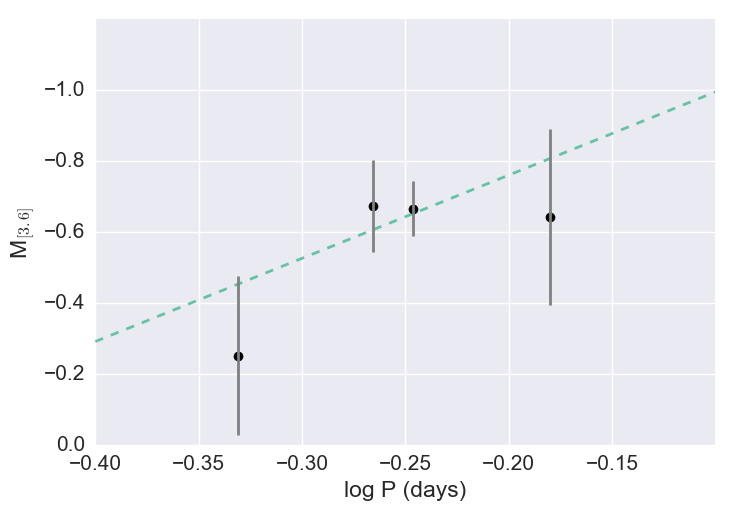

In [14]:
## plot the plz relation

p1 = np.arange(-0.4,-0.1,0.05)
feh1 = np.mean(rrab_cal_df.Fe_H)
axp1 = mp.subplot(111)

axp1.plot(p1, -2.342*p1 + zp_36 + feh1*feh_36, ls='--', label="[3.6]")
axp1.errorbar(rrab_cal_df.logP, rrab_cal_df.M_abs_3p6, yerr=rrab_cal_df.M_err_3p6, ls='None',zorder=4, color='Grey',)
axp1.plot(rrab_cal_df.logP, rrab_cal_df.M_abs_3p6, 'ko', ls='None')
axp1.invert_yaxis()
mp.xlabel('log P (days)')
mp.ylabel('M$_{[3.6]}$')
myaxis=[-0.4, -0.1, 0.0, -1.2]
axp1.axis(myaxis)

print('zp = ({0:.3f} $\pm$ {1:.3f}) fe_h = ({2:.3f} $\pm$ {3:.3f})'.format(zp_36, e_zp_36, feh_36, e_feh_36))

### For comparison: Neeley et al. (2015) Figure 10(a)
* PL relation using 5 RRL (RRab + RRc (fundamentalised))

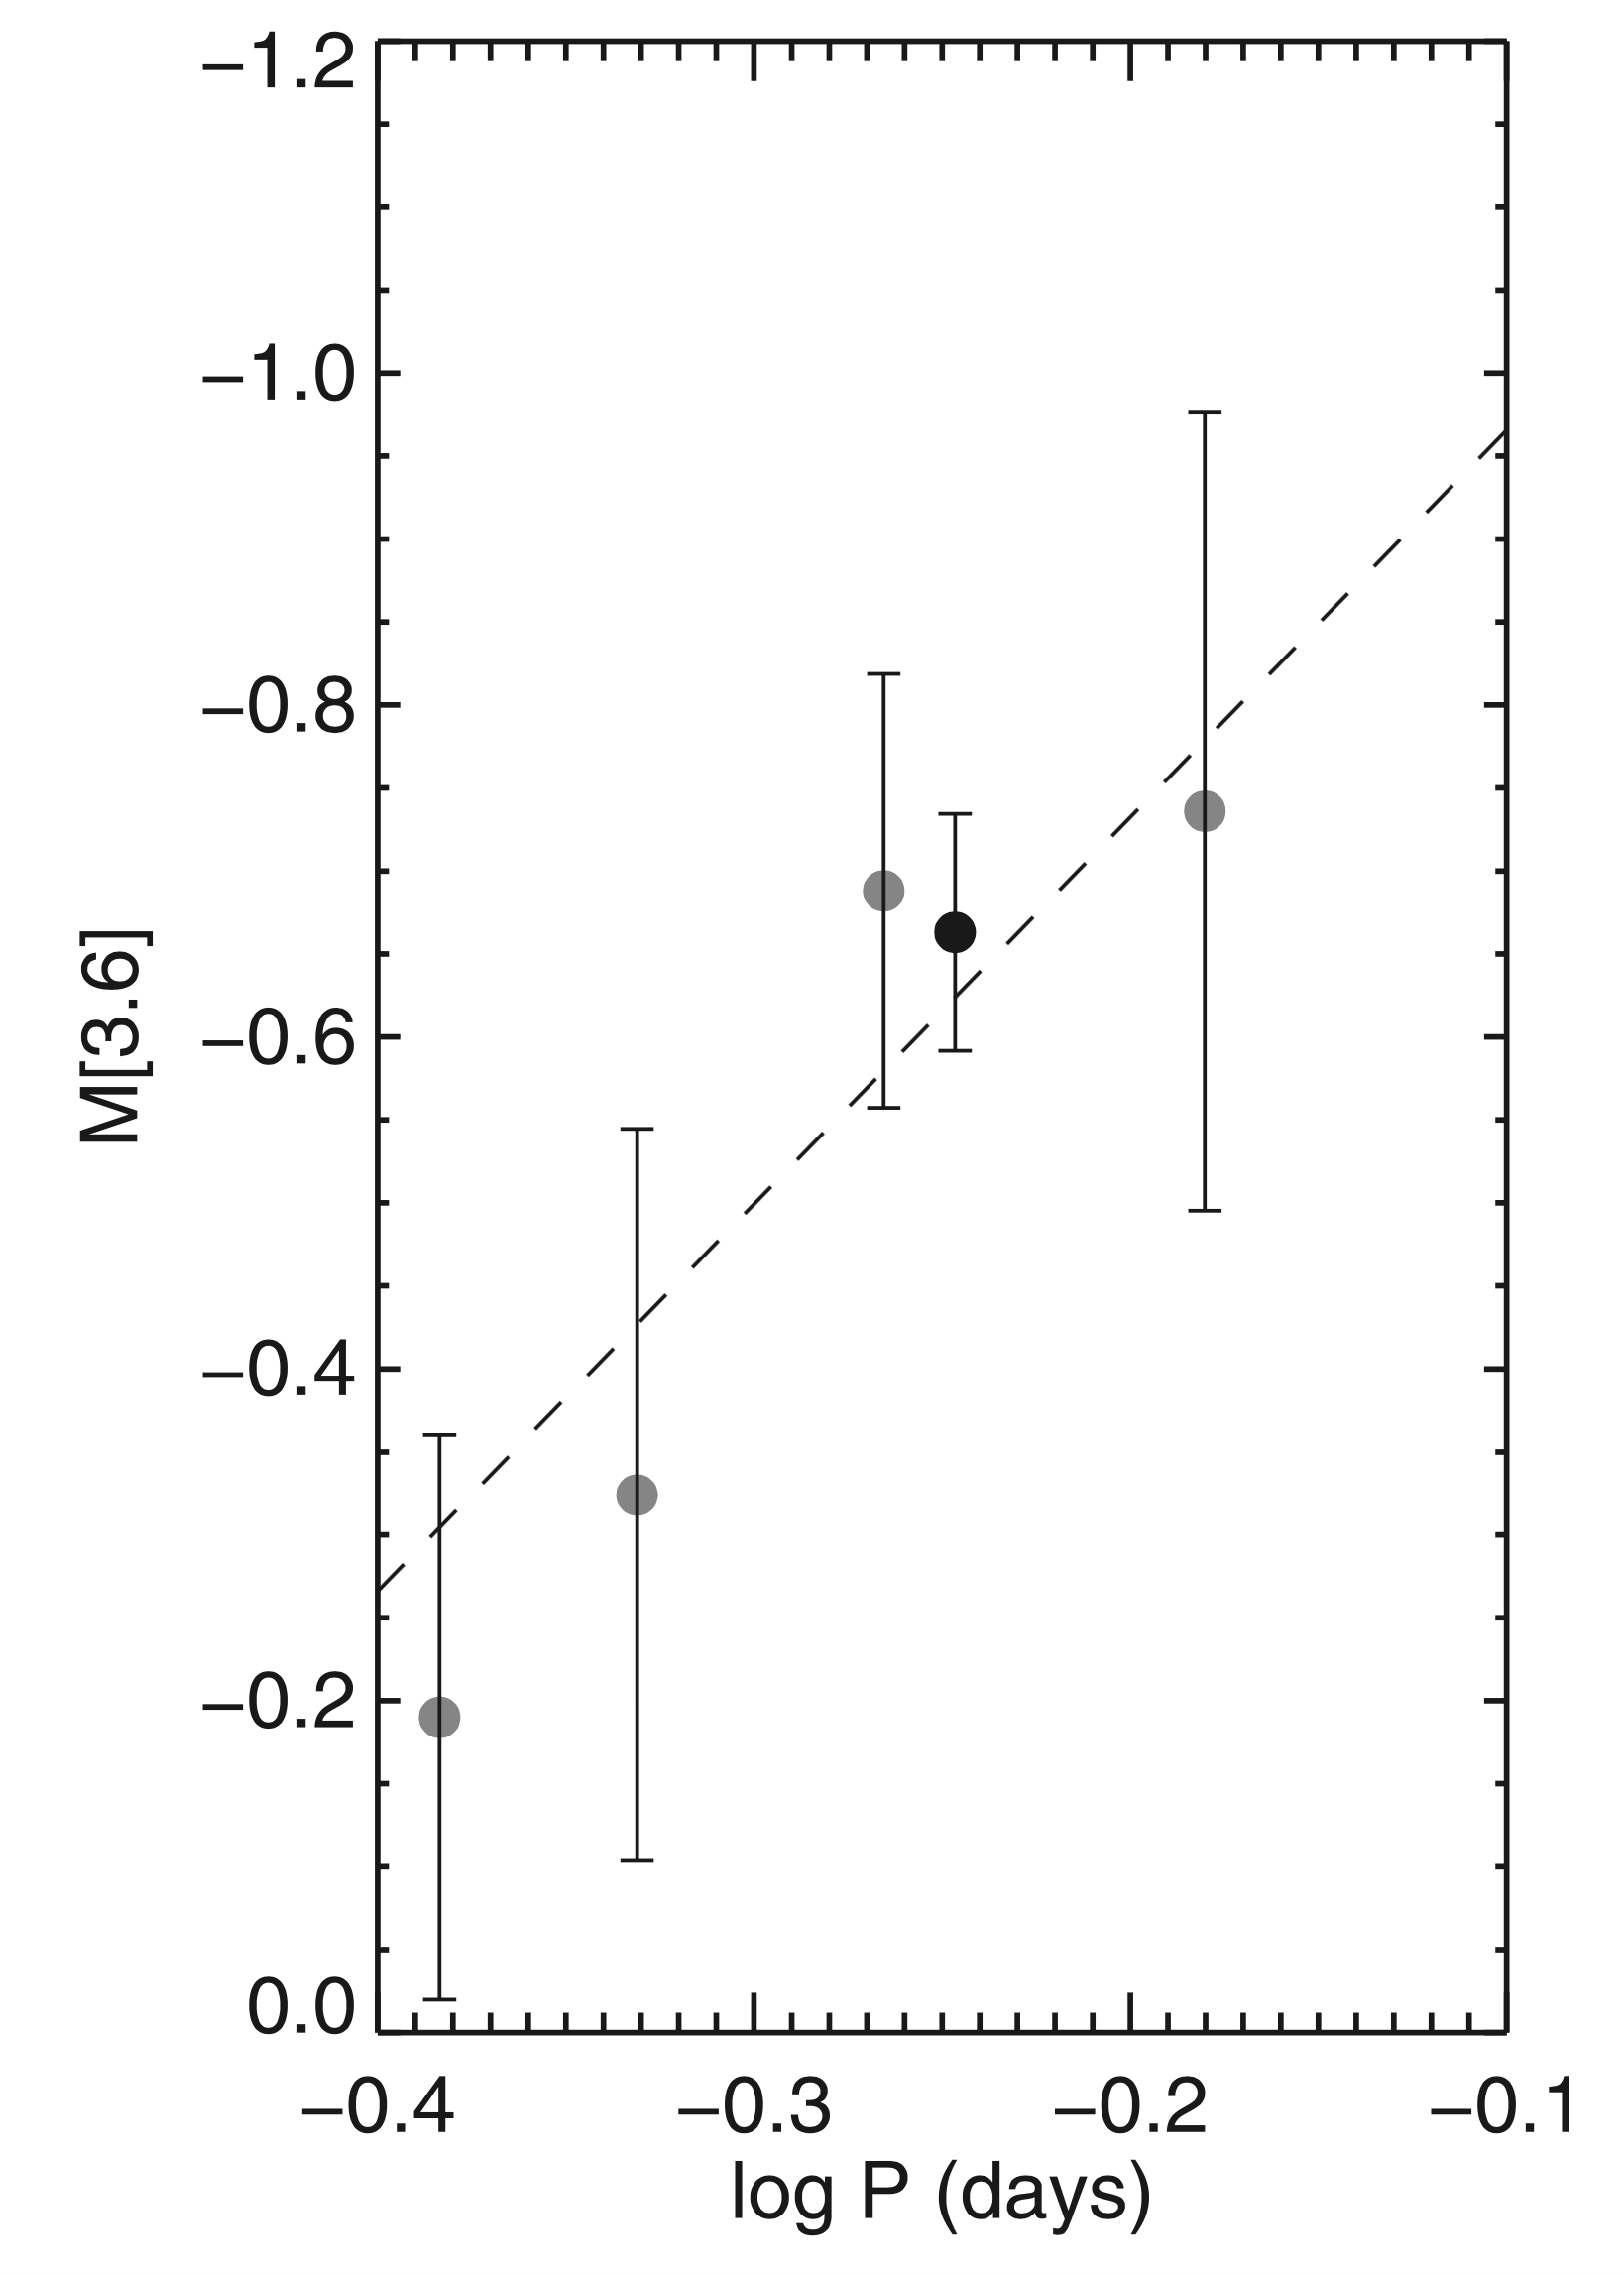

In [15]:
Image('neeley_fig10a.png', width=400)

## Abs mag differences between Neeley and this analysis?
* Any differences in absolute magnitude in Neeley analysis and this one should be due to these factors:

 1) Slight change in Spitzer calibration when Neeley analysis was initially performed
 
 2) This analysis doesn't use the Lutz-Kelker correction
 
 3) Different extinction values (but how different are they?

In [16]:
### name order = xycyg, sudra, rrlyr, uvoct, 
rrab_cal_df['neeley_abs'] = [-0.324, -0.736, -0.663, -0.688]
rrab_cal_df['neeley_abs_sigma'] = [0.221, 0.0241, 0.071, 0.131]
rrab_cal_df['neeley_lkh'] = [-0.09, -0.11, -0.02, -0.03]
rrab_cal_df['neeley_A_36'] = [0.020, 0.002, 0.009, 0.018]

In [17]:
rrab_cal_df['delta_mag'] = rrab_cal_df.apply(lambda x: (x.M_abs_3p6 - x.neeley_abs), axis=1)

In [18]:
rrab_cal_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0      xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
1      sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
2      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
3      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   

  RRL_type  Fe_H    Name    ...      e_A_4p5        mu      e_mu  M_err_3p6  \
0     RRab -1.44  XZ Cyg    ...      0.00057  8.886418  0.221816   0.222898   
1     RRab -1.80  SU Dra    ...      0.00003  9.238558  0.245716   0.246659   
2     RRab -1.39  RR Lyr    ...      0.00045  7.118293  0.074908   0.078053   
3     RRab -1.74  UV Oct    ...      0.00045  8.835019  0.127132   0.129010   

   M_err_4p5  neeley_abs  neeley_abs_sigma  neeley_lkh  neeley_A_36  delta_mag  
0   0.222860      -0.324            0.2210       -0.09        0.020   0.071582  
1   0.246693      -0.736            0.0241       -0.11        0.002   0.093442  
2   0.078053      -0.663            0.0710       -0.02        0.009  -0.003293  
3   0.129010      -0.688            0.1310       -0.03        0.018   0.014981  

[4 rows x 27 columns]

In [19]:
def delta_mag_fit(x, m, c):
    return m*x + c

-1.03150497271 -0.0202912156318


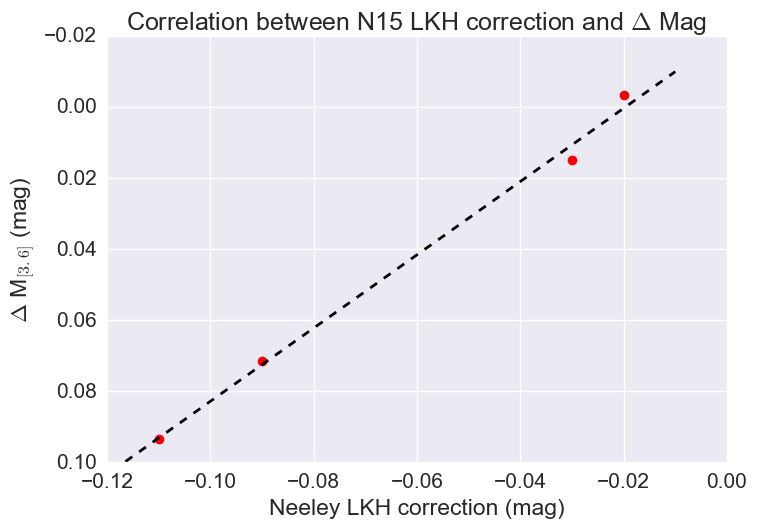

In [20]:
p1 = np.arange(-0.15, 0.0, 0.01)
result = curve_fit(delta_mag_fit, rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.axis([-0.12, 0.00, 0.10, -0.02])
mp.xlabel('Neeley LKH correction (mag)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag)')
mp.title('Correlation between N15 LKH correction and $\Delta$ Mag')

print (slope, zp)

In [21]:
rrab_cal_df['delta_red'] = rrab_cal_df.apply(lambda x: (x.A_3p6 - x.neeley_A_36), axis=1)

-6.38937617513 0.0633459736861


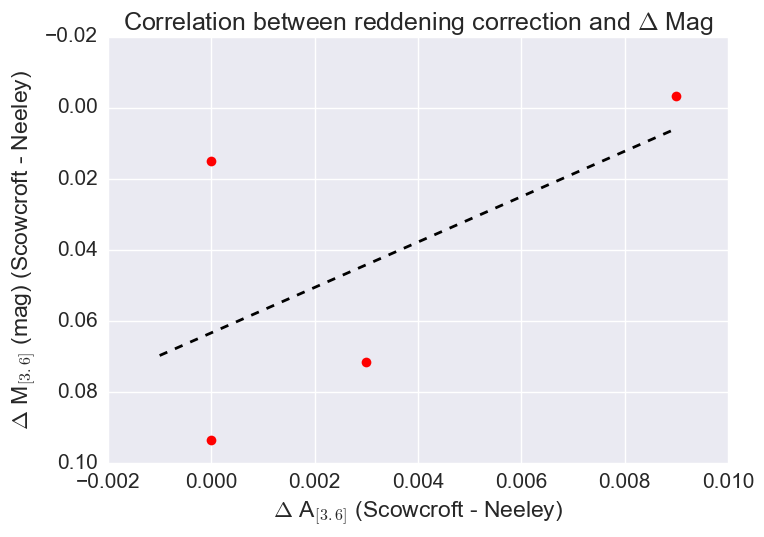

In [22]:
p1 = np.arange(-0.001, 0.01, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_red, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_red, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ A$_{[3.6]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between reddening correction and $\Delta$ Mag')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.10, -0.02])



print (slope, zp)

Uncertainties on the absolute magnitudes are very consistent between the two analyses. I think the small differences are because of the treatment of uncertainties in extinction.

In [23]:
rrab_cal_df['M_err_3p6'], rrab_cal_df['neeley_abs_sigma']

(0    0.222898
 1    0.246659
 2    0.078053
 3    0.129010
 Name: M_err_3p6, dtype: float64, 0    0.2210
 1    0.0241
 2    0.0710
 3    0.1310
 Name: neeley_abs_sigma, dtype: float64)

-7.30881285038 -0.0892079893587


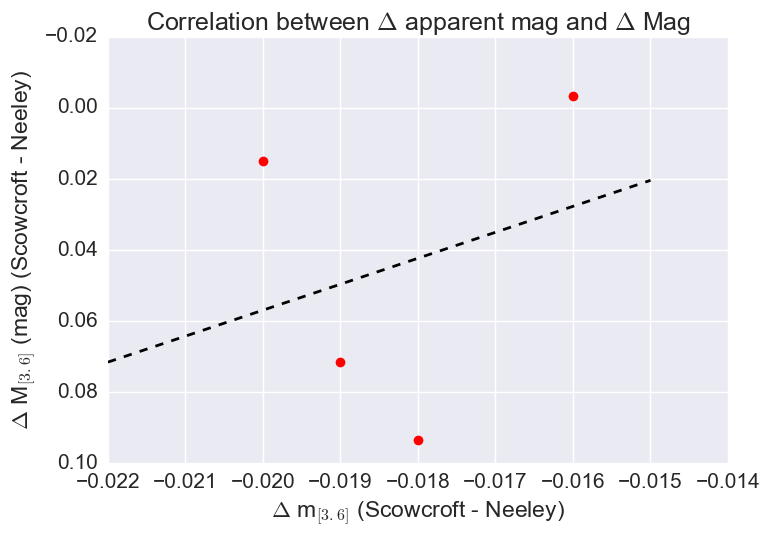

In [24]:
rrab_cal_df['neeley_app_mag'] = [8.676, 8.616, 6.486, 8.200]
rrab_cal_df['delta_app_mag'] = rrab_cal_df.apply(lambda x: (x.mag_3p6 - x.neeley_app_mag), axis=1)

p1 = np.arange(-0.022, -0.014, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_app_mag, rrab_cal_df.delta_mag)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_app_mag, rrab_cal_df.delta_mag, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ m$_{[3.6]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[3.6]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between $\Delta$ apparent mag and $\Delta$ Mag')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.10, -0.02])



print (slope, zp)

* Maximum difference in apparent magnitude is -0.02 mag
* Range is -0.02 to -0.016 mag
* These changes are not due to the changes in photometry

## Changes in the PLZ are due to this analysis not using the LKH correction, which we have made the decision not to apply.

# RRab [3.6] PLZ Relation from Galactic Calibrators:

$M_{[3.6]} = -2.342 \log P$ {{"%+.3f" % feh_36}} ($\pm$ {{"%.3f" % e_feh_36}})  $\text{[Fe/H]}$  {{"%+.3f" % zp_36}} ($\pm$ {{"%.3f" % e_zp_36}})





## Repeat above analysis for [4.5]

zp = (-1.193 $\pm$ 0.325) fe_h = (0.031 $\pm$ 0.143)


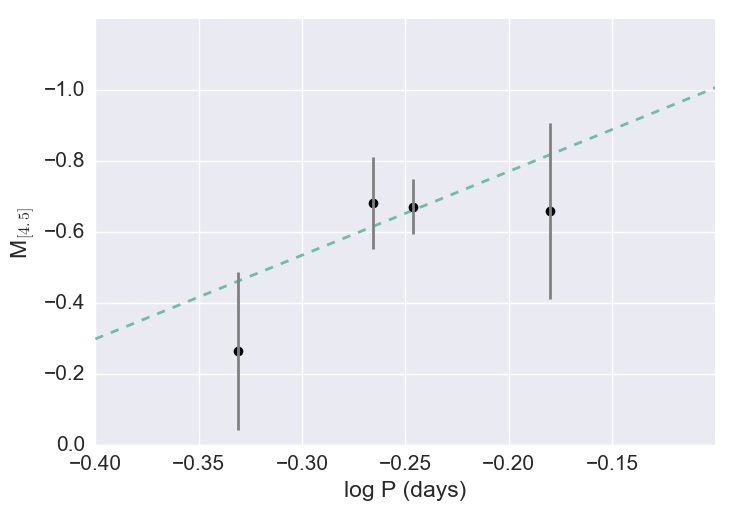

In [25]:
result = curve_fit(M4_ab_45, (rrab_cal_df.logP, rrab_cal_df.Fe_H), rrab_cal_df.M_abs_4p5, sigma=rrab_cal_df.M_err_4p5, absolute_sigma=True) ### make this work

zp_45 = result[0][0]
feh_45 = result[0][1]

e_zp_45 = result[1][0,0]
e_feh_45 = result[1][1,1]

p1 = np.arange(-0.4,-0.1,0.05)
feh1 = np.mean(rrab_cal_df.Fe_H)
axp1 = mp.subplot(111)

axp1.plot(p1, -2.358*p1 + zp_45 + feh1*feh_45, ls='--', label="[4.5]")
axp1.errorbar(rrab_cal_df.logP, rrab_cal_df.M_abs_4p5, yerr=rrab_cal_df.M_err_4p5, ls='None',zorder=4, color='Grey',)
axp1.plot(rrab_cal_df.logP, rrab_cal_df.M_abs_4p5, 'ko', ls='None')
axp1.invert_yaxis()
mp.xlabel('log P (days)')
mp.ylabel('M$_{[4.5]}$')
myaxis=[-0.4, -0.1, 0.0, -1.2]
axp1.axis(myaxis)

print('zp = ({0:.3f} $\pm$ {1:.3f}) fe_h = ({2:.3f} $\pm$ {3:.3f})'.format(zp_45, e_zp_45, feh_45, e_feh_45))

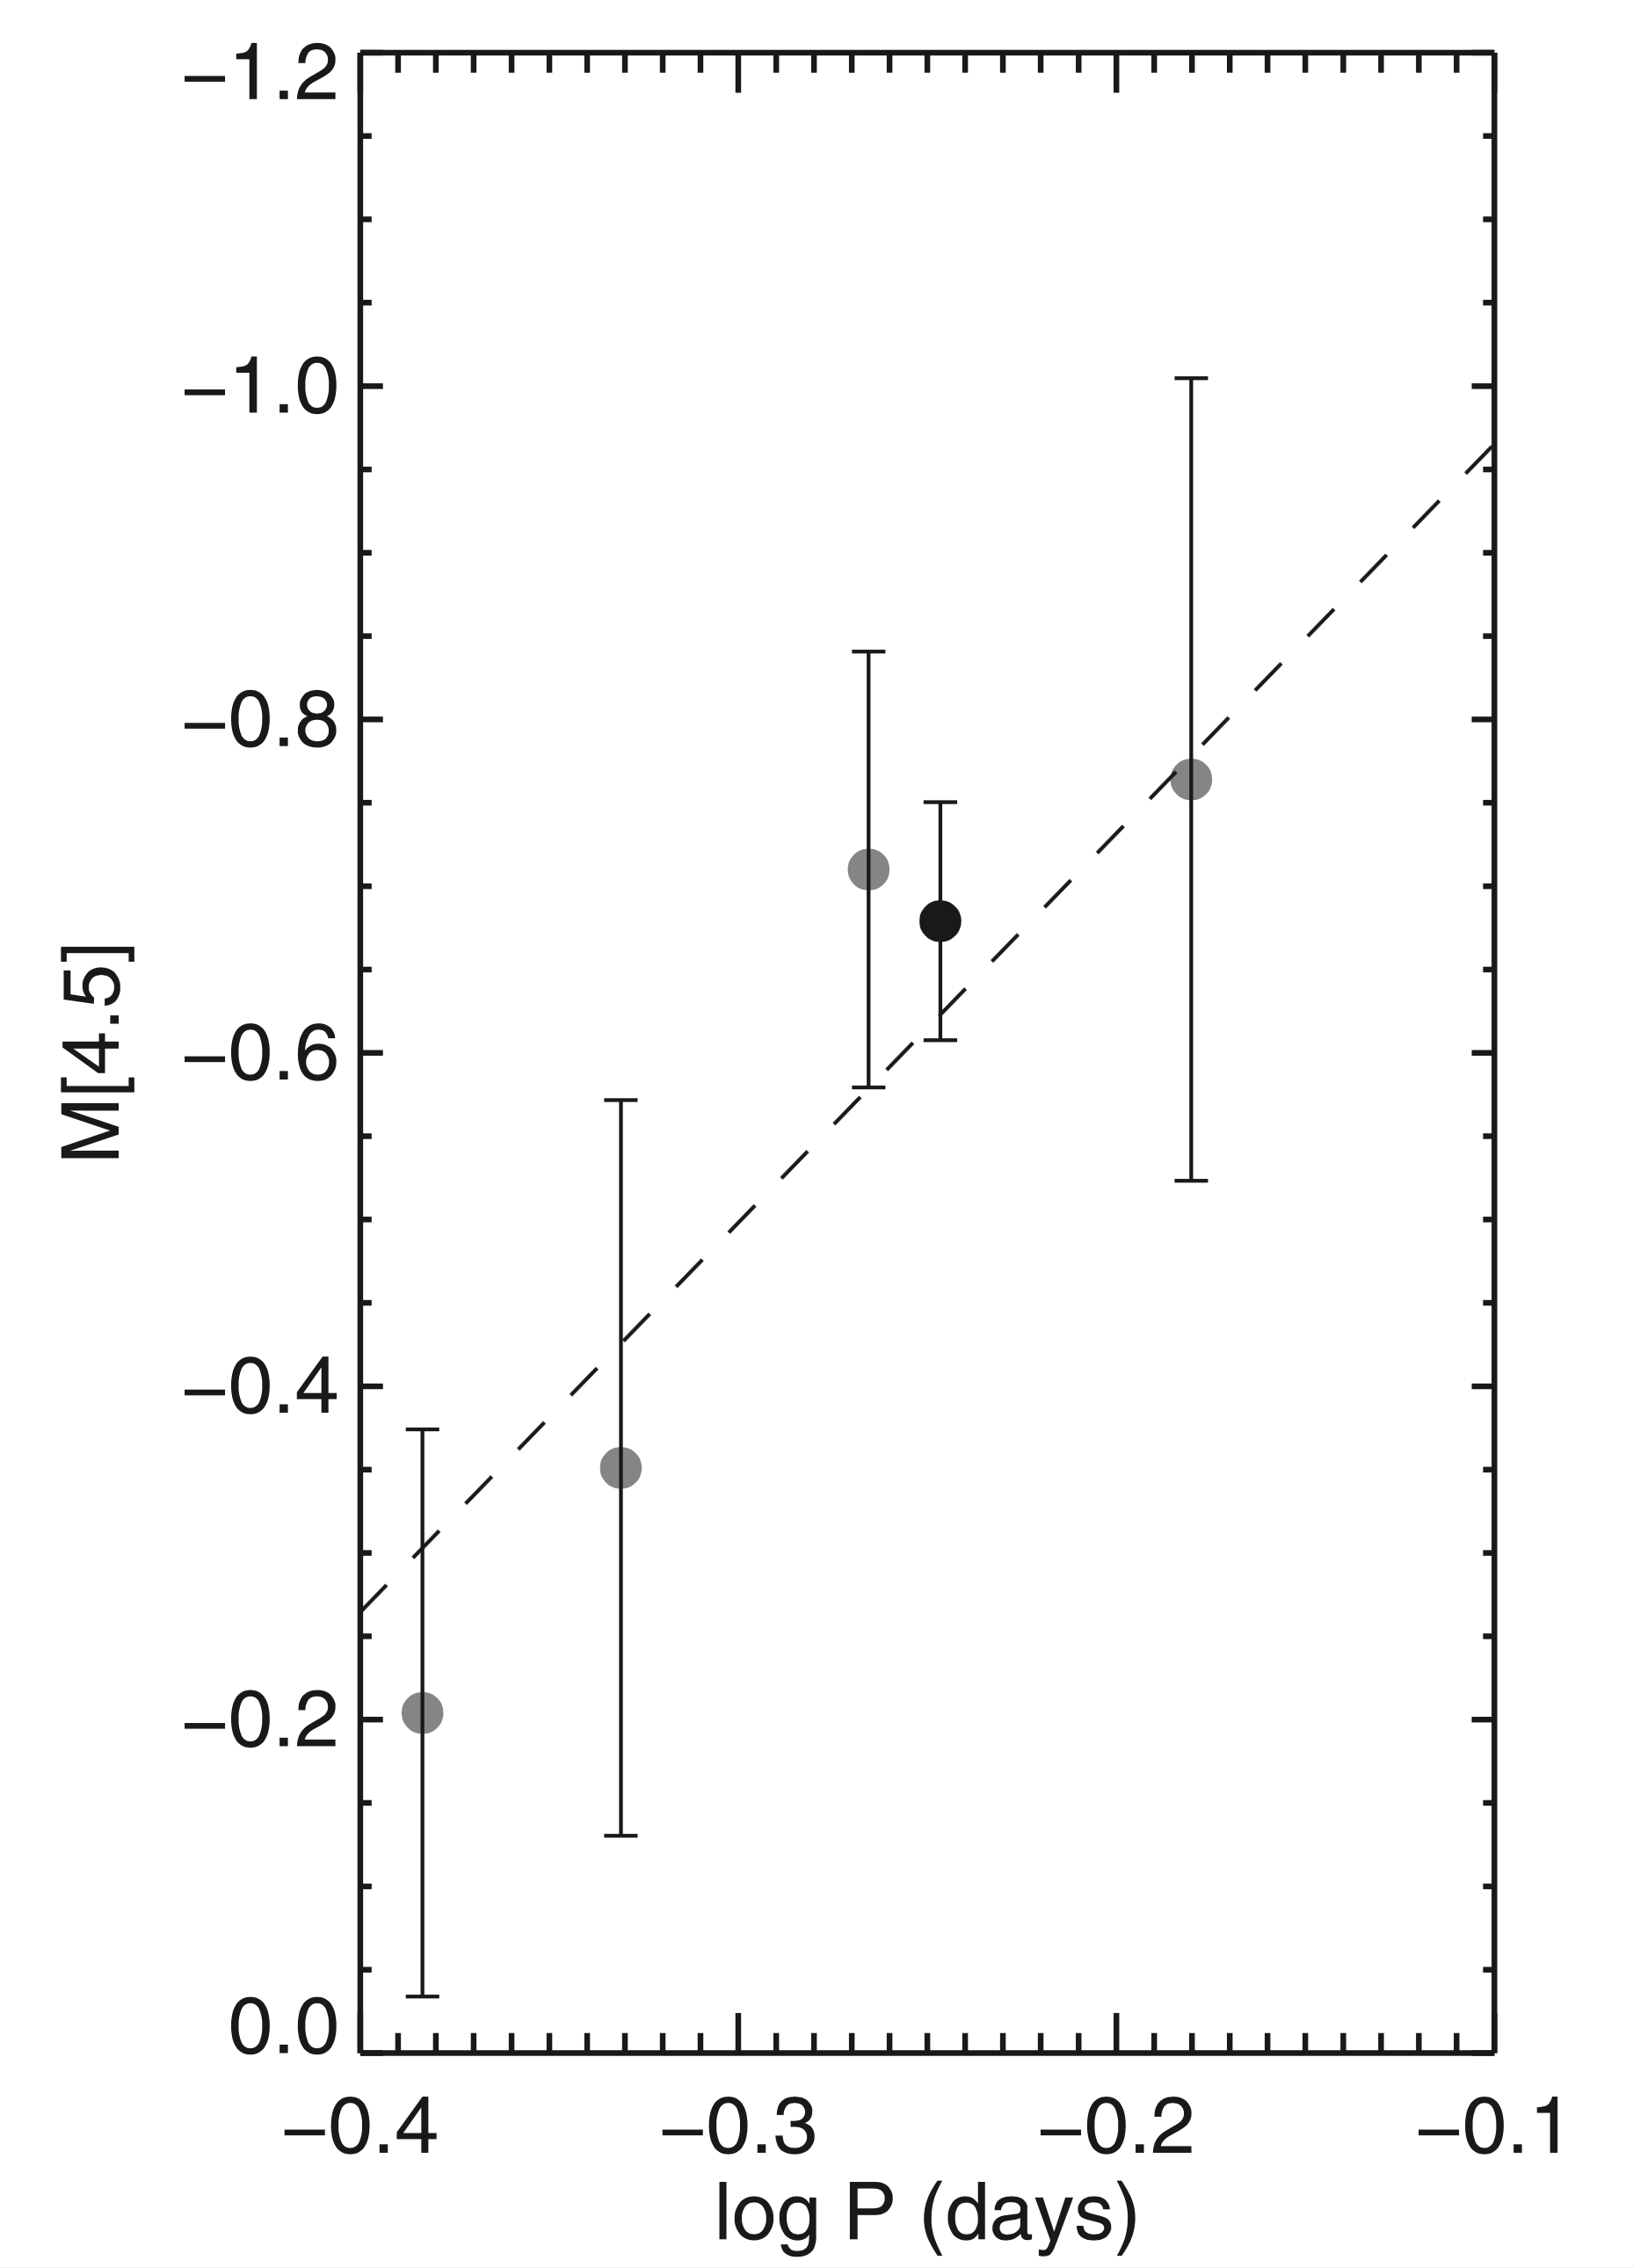

In [26]:
Image('neeley_fig10b.png', width=400)

In [27]:
rrab_cal_df['neeley_abs_45'] = [-0.361, -0.764, -0.679, -0.710]
rrab_cal_df['neeley_abs_sigma_45'] = [0.221, 0.0241, 0.071, 0.131]
rrab_cal_df['neeley_lkh'] = [-0.09, -0.11, -0.02, -0.03]
rrab_cal_df['neeley_A_45'] = [0.016, 0.002, 0.007, 0.014]

In [28]:
rrab_cal_df['delta_mag_45'] = rrab_cal_df.apply(lambda x: (x.M_abs_4p5 - x.neeley_abs_45), axis=1)

-1.08937731363 -0.00990823694087


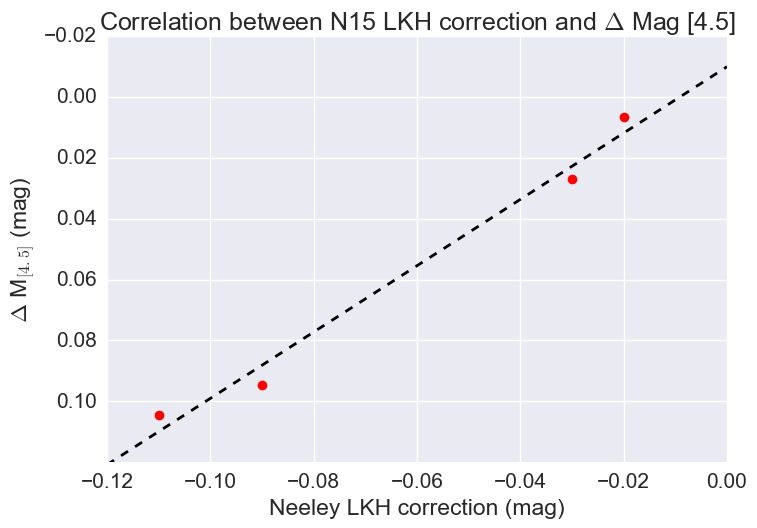

In [29]:
p1 = np.arange(-0.12, 0.01, 0.01)
result = curve_fit(delta_mag_fit, rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.neeley_lkh, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.axis([-0.12, 0.00, 0.12, -0.02])
mp.xlabel('Neeley LKH correction (mag)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag)')
mp.title('Correlation between N15 LKH correction and $\Delta$ Mag [4.5]')

print (slope, zp)

In [30]:
rrab_cal_df['delta_red_45'] = rrab_cal_df.apply(lambda x: (x.A_4p5 - x.neeley_A_45), axis=1)

-8.49198644103 0.0815308078736


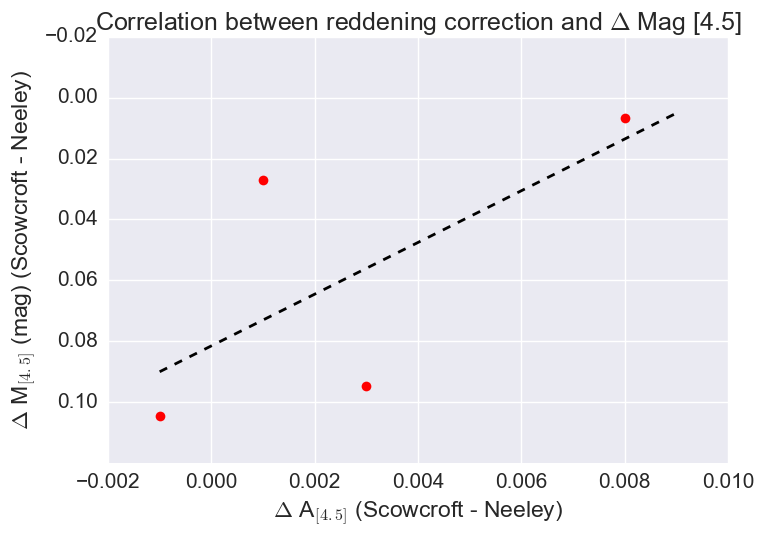

In [31]:
p1 = np.arange(-0.001, 0.01, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_red_45, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_red_45, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ A$_{[4.5]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between reddening correction and $\Delta$ Mag [4.5]')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.12, -0.02])



print (slope, zp)

-4.92968699315 0.0236700362087


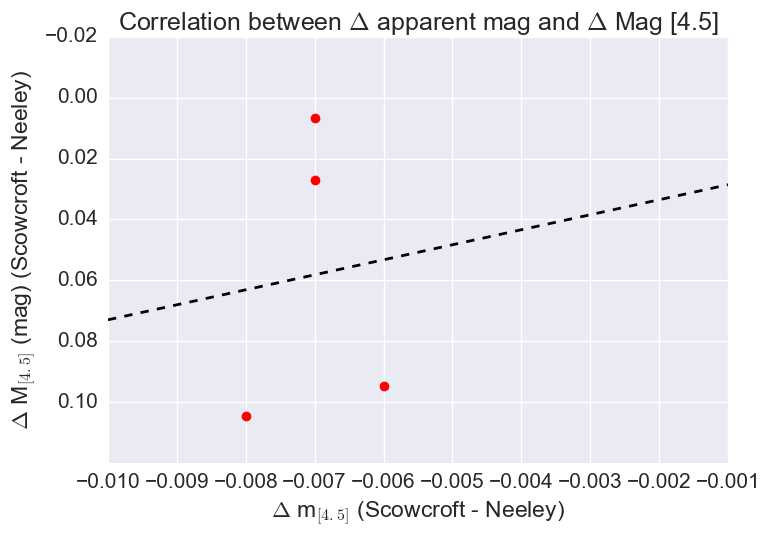

In [32]:
rrab_cal_df['neeley_app_mag_45'] = [8.645, 8.588, 6.468, 8.174]
rrab_cal_df['delta_app_mag_45'] = rrab_cal_df.apply(lambda x: (x.mag_4p5 - x.neeley_app_mag_45), axis=1)

p1 = np.arange(-0.01, -0.0, 0.001)
result = curve_fit(delta_mag_fit, rrab_cal_df.delta_app_mag_45, rrab_cal_df.delta_mag_45)

slope = result[0][0]
zp = result[0][1]
e_slope = result[1][0,0]
e_zp = result[1][1,1]

axp1 = mp.subplot(111)
axp1.plot(rrab_cal_df.delta_app_mag_45, rrab_cal_df.delta_mag_45, 'ro')
axp1.plot(p1, slope*p1 + zp, 'k--')
axp1.invert_yaxis()
mp.xlabel('$\Delta$ m$_{[4.5]}$ (Scowcroft - Neeley)')
mp.ylabel('$\Delta$ M$_{[4.5]}$ (mag) (Scowcroft - Neeley)')
mp.title('Correlation between $\Delta$ apparent mag and $\Delta$ Mag [4.5]')
x1,x2,y1,y2 = mp.axis()
mp.axis([x1, x2, 0.12, -0.02])



print (slope, zp)

Same in [4.5] as in [3.6] - the difference in absolute mags is down the the choice of whether to use the LKH correction. Very slight difference is due to the Spitzer calibration and the uncertainties on the extinction corrections.

Using the IRSA extinctions is more consistent because they can be applied over the whole sky.

# RRab [4.5] PLZ Relation from Galactic Calibrators:

$M_{[4.5]} = -2.358 \log P$ {{"%+.3f" % feh_45}} ($\pm$ {{"%.3f" % e_feh_45}})  $\text{[Fe/H]}$  {{"%+.3f" % zp_45}} ($\pm$ {{"%.3f" % e_zp_45}})




# Application of the PLZ relation to the full CRRP RRab set

## Step 2 - Testing the PLZ relations
* Apply the PLZ relations to the CRRP data set
* Have [3.6] and [4.5] data for all the CRRP Galactic RRL
* Also have metallcities from Monson et al.

Question: If I use the PLZ relation to derive a distance to each of these stars, how well do those distances agree with the Gaia DR1 distances?

In [33]:
rrab_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       xxand    9.409    0.009    9.384    0.008  0.722757  2456751.00   
2       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
3        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
4       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
5       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
6       rrcet    8.501    0.009    8.489    0.008  0.553029  2456750.25   
7        wcrt   10.506    0.011   10.500    0.011  0.412015  2456750.25   
8       uycyg    9.709    0.009    9.688    0.008  0.560705  2456750.50   
9       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
10      dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
11      sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
12      swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
13      rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
14      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
15      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
16      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
17      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
18      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
19       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
20      rrleo    9.658    0.008    9.630    0.008  0.452393  2456750.75   
21      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
22      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
23      rvoct    9.492    0.011    9.480    0.011  0.571163  2456750.50   
24      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
25      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
26      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
27      bbpup   10.875    0.011   10.873    0.011  0.480549  2456750.00   
28      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
29      ruscl    9.172    0.009    9.148    0.009  0.493355  2456750.25   
30      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
31   v0440sgr    9.038    0.009    9.022    0.008  0.477479  2456750.75   
32   v0675sgr    8.954    0.009    8.929    0.009  0.642289  2456750.75   
33      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
34      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
35      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
36      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H       Name  A_3p6  A_4p5  M_abs_3p6  M_abs_4p5  calibrator  \
0      RRab -0.24     SW And  0.008  0.007      8.477      8.465         0.0   
1      RRab -1.94     XX And  0.008  0.007      9.401      9.377         0.0   
2      RRab -1.48     WY Ant  0.012  0.010      9.555      9.538         0.0   
3      RRab -2.43      X Ari  0.037  0.031      7.848      7.828         0.0   
4      RRab -1.76     ST Boo  0.004  0.003      9.830      9.813         0.0   
5      RRab -2.56     UY Boo  0.007  0.006      9.714      9.690         0.0   
6      RRab -1.45     RR Cet  0.004  0.003      8.497      8.486         0.0   
7      RRab -0.54      W Crt  0.009  0.007     10.497     10.493         0.0   
8      RRab -0.80     UY Cyg  0.047  0.039      9.662      9.649         0.0   
9      RRab -1.44     XZ Cyg  0.023  0.019      8.634      8.620         1.0   
10     RRab -0.39     DX Del  0.024  0.020      8.626      8.617         0.0   
11     RRab -1.80     SU Dra  0.002  0.001      8.596      8.579         1.0   
12     RRab -1.12     SW Dra  0.003  0.002      9.300      9.283         0.0   
13     RRab -1.33     RX Eri  0.

In [34]:
def PL_36(period, feh):
    return -2.342 * np.log10(period) + 0.017*feh -1.202

def PL_45(period, feh):
    return -2.358 * np.log10(period) + 0.031*feh - 1.193

In [35]:
rrab_df['M36_derived'] = rrab_df.apply(lambda x: PL_36(x.P_final, x.Fe_H) - x.A_3p6, axis=1)
rrab_df['M45_derived'] = rrab_df.apply(lambda x: PL_45(x.P_final, x.Fe_H) - x.A_4p5, axis=1)



In [36]:
rrab_df['mu_36_derived'] = rrab_df.apply(lambda x: x.mag_3p6 - x.M36_derived, axis=1)
rrab_df['mu_45_derived'] = rrab_df.apply(lambda x: x.mag_4p5 - x.M45_derived, axis=1)

In [37]:
rrab_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       xxand    9.409    0.009    9.384    0.008  0.722757  2456751.00   
2       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
3        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
4       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
5       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
6       rrcet    8.501    0.009    8.489    0.008  0.553029  2456750.25   
7        wcrt   10.506    0.011   10.500    0.011  0.412015  2456750.25   
8       uycyg    9.709    0.009    9.688    0.008  0.560705  2456750.50   
9       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
10      dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
11      sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
12      swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
13      rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
14      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
15      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
16      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
17      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
18      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
19       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
20      rrleo    9.658    0.008    9.630    0.008  0.452393  2456750.75   
21      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
22      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
23      rvoct    9.492    0.011    9.480    0.011  0.571163  2456750.50   
24      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
25      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
26      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
27      bbpup   10.875    0.011   10.873    0.011  0.480549  2456750.00   
28      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
29      ruscl    9.172    0.009    9.148    0.009  0.493355  2456750.25   
30      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
31   v0440sgr    9.038    0.009    9.022    0.008  0.477479  2456750.75   
32   v0675sgr    8.954    0.009    8.929    0.009  0.642289  2456750.75   
33      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
34      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
35      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
36      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H       Name      ...        M_abs_3p6  M_abs_4p5  calibrator  \
0      RRab -0.24     SW And      ...            8.477      8.465         0.0   
1      RRab -1.94     XX And      ...            9.401      9.377         0.0   
2      RRab -1.48     WY Ant      ...            9.555      9.538         0.0   
3      RRab -2.43      X Ari      ...            7.848      7.828         0.0   
4      RRab -1.76     ST Boo      ...            9.830      9.813         0.0   
5      RRab -2.56     UY Boo      ...            9.714      9.690         0.0   
6      RRab -1.45     RR Cet      ...            8.497      8.486         0.0   
7      RRab -0.54      W Crt      ...           10.497     10.493         0.0   
8      RRab -0.80     UY Cyg      ...            9.662      9.649         0.0   
9      RRab -1.44     XZ Cyg      ...            8.634      8.620         1.0   
10     RRab -0.39     DX Del      ...            8.626      8.617         0.0   
11     RRab -1.80     SU Dra      ...            8.596      8.579         1.0   
12     RRab -1.12     SW Dra      ...            9.300      9.283         0.0   
13     RRab -1.33 

In [38]:
### Gaia data:
gaia_df = pd.read_csv('rr_calibrators.csv', header=0, sep=',')

gaia_df file is a merged data file that I created at the gaia sprints. Original data is all in the gaia_sprints folder on github. All raw data straight from the DR1 release and the same data in these spitzer files (i.e. data that went into Monson 2017).

In [39]:
### grabbing the relavent columns from gaia_df

gaia_columns = ['Name', 'id_compare', 'Plx', 'e_Plx']
gaia_sel_df = gaia_df[gaia_columns]
gaia_sel_df.rename(columns={'id_compare':'Name_lower'}, inplace=True)

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [40]:
rrab_gaia_df = rrab_df.merge(gaia_sel_df, on='Name_lower')

In [41]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
4       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x  ...        logP  e_A_3p6  e_A_4p5  M36_derived  \
0      RRab -0.24  SW And  ...   -0.354322  0.00024  0.00021    -0.384258   
1      RRab -1.48  WY Ant  ...   -0.240827  0.00036  0.00030    -0.675144   
2      RRab -2.43   X Ari  ...   -0.186304  0.00111  0.00093    -0.843987   
3      RRab -1.76  ST Boo  ...   -0.206010  0.00012  0.00009    -0.753445   
4      RRab -2.56  UY Boo  ...   -0.186532  0.00021  0.00018    -0.815661   
5      RRab -1.44  XZ Cyg  ...   -0.331056  0.00069  0.00057    -0.474147   
6      RRab -0.39  DX Del  ...   -0.325491  0.00072  0.00060    -0.470330   
7      RRab -1.80  SU Dra  ...   -0.180180  0.00006  0.00003    -0.812619   
8      RRab -1.12  SW Dra  ...   -0.244377  0.00009  0.00006    -0.651710   
9      RRab -1.33  RX Eri  ...   -0.231180  0.00036  0.00030    -0.695187   
10     RRab -1.70  SV Eri  ...   -0.146391  0.00048  0.00042    -0.904052   
11     RRab -0.29  RR Gem  ...   -0.400892  0.00036  0.00030    -0.280040   
12     RRab -0.69  TW Her  ...   -0.398374  0.00024  0.00018    -0.288737   
13     RRab -1.58  VX Her  ...   -0.341645  0.00027  0.00021    -0.437727   
14     RRab -1.50  SV Hya  ...   -0.320079  0.00045  0.00039    -0.492874   
15     RRab -1.50   V Ind  ...   -0.319119  0.00027  0.00021    -0.489123   
16     RRab -1.56  TT Lyn  ...   -0.223710  0.00009  0.00009    -0.707592   
17     RRab -1.39  RR Lyr  ...   -0.246541  0.00054  0.00045    -0.666231   
18     RRab -1.74  UV Oct  ...   -0.265536  0.00054  0.00045    -0.627694   
19     RRab -0.08  AV Peg  ...   -0.408518  0.00039  0.00033    -0.259610   
20     RRab -1.22  BH Peg  ...   -0.193147  0.00045  0.00036    -0.785390   
21     RRab -1.11  HK Pup  ...   -0.134181  0.00192  0.00159    -0.970617   
22     RRab -0.07  AN Ser  ...   -0.282270  0.00021  0.00018    -0.549114   
23     RRab -0.49  AB UMa  ...   -0.222152  0.00015  0

# rrab_gaia_df has 27 RRab with Gaia DR1 parallaxes, Spitzer photometry and Monson [Fe/H] metallicities where we can test this calibration

## Full sample has 37 stars

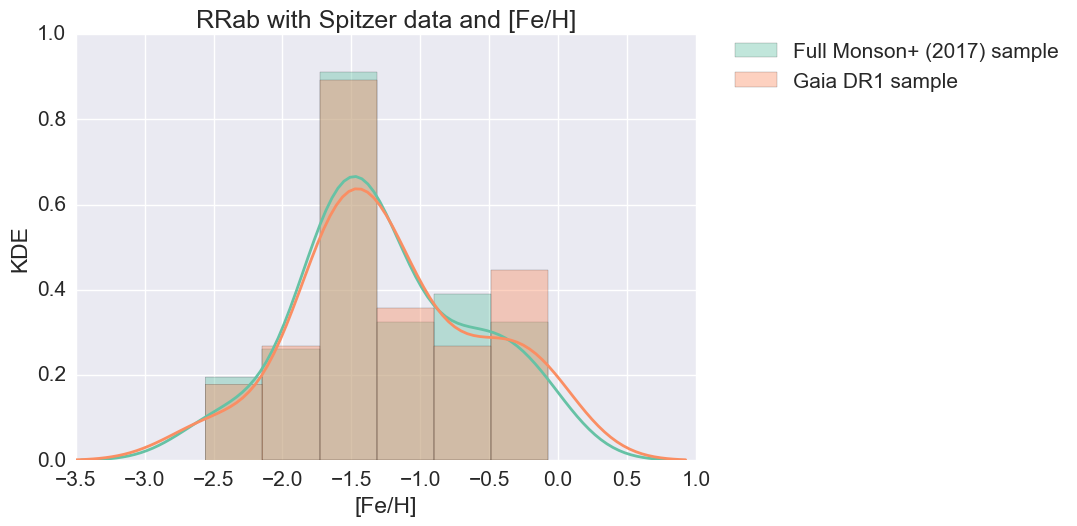

In [42]:
### histogram of the metallicities of these stars, out of interest:

axp1 = sns.distplot(rrab_df.Fe_H, bins=6, label='Full Monson+ (2017) sample')
axp1 = sns.distplot(rrab_gaia_df.Fe_H, bins=6, label='Gaia DR1 sample')
mp.xlabel('[Fe/H]')
mp.title('RRab with Spitzer data and [Fe/H]')
mp.axis([-3.5, 1.0, 0, 1.0])
mp.ylabel('KDE')
mp.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [43]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
4       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x  ...        logP  e_A_3p6  e_A_4p5  M36_derived  \
0      RRab -0.24  SW And  ...   -0.354322  0.00024  0.00021    -0.384258   
1      RRab -1.48  WY Ant  ...   -0.240827  0.00036  0.00030    -0.675144   
2      RRab -2.43   X Ari  ...   -0.186304  0.00111  0.00093    -0.843987   
3      RRab -1.76  ST Boo  ...   -0.206010  0.00012  0.00009    -0.753445   
4      RRab -2.56  UY Boo  ...   -0.186532  0.00021  0.00018    -0.815661   
5      RRab -1.44  XZ Cyg  ...   -0.331056  0.00069  0.00057    -0.474147   
6      RRab -0.39  DX Del  ...   -0.325491  0.00072  0.00060    -0.470330   
7      RRab -1.80  SU Dra  ...   -0.180180  0.00006  0.00003    -0.812619   
8      RRab -1.12  SW Dra  ...   -0.244377  0.00009  0.00006    -0.651710   
9      RRab -1.33  RX Eri  ...   -0.231180  0.00036  0.00030    -0.695187   
10     RRab -1.70  SV Eri  ...   -0.146391  0.00048  0.00042    -0.904052   
11     RRab -0.29  RR Gem  ...   -0.400892  0.00036  0.00030    -0.280040   
12     RRab -0.69  TW Her  ...   -0.398374  0.00024  0.00018    -0.288737   
13     RRab -1.58  VX Her  ...   -0.341645  0.00027  0.00021    -0.437727   
14     RRab -1.50  SV Hya  ...   -0.320079  0.00045  0.00039    -0.492874   
15     RRab -1.50   V Ind  ...   -0.319119  0.00027  0.00021    -0.489123   
16     RRab -1.56  TT Lyn  ...   -0.223710  0.00009  0.00009    -0.707592   
17     RRab -1.39  RR Lyr  ...   -0.246541  0.00054  0.00045    -0.666231   
18     RRab -1.74  UV Oct  ...   -0.265536  0.00054  0.00045    -0.627694   
19     RRab -0.08  AV Peg  ...   -0.408518  0.00039  0.00033    -0.259610   
20     RRab -1.22  BH Peg  ...   -0.193147  0.00045  0.00036    -0.785390   
21     RRab -1.11  HK Pup  ...   -0.134181  0.00192  0.00159    -0.970617   
22     RRab -0.07  AN Ser  ...   -0.282270  0.00021  0.00018    -0.549114   
23     RRab -0.49  AB UMa  ...   -0.222152  0.00015  0

# Comparison of derived parallax to observed parallax

* Comparing $\varpi_{gaia}$ to $\varpi_{spitzer}$ where $\varpi_{gaia}$ is the Gaia parallax and $\varpi_{spitzer}$ is the parallax derived by converting from apparent magnitude through distance to parallax.

$$ \varpi_{spitzer} = \dfrac{1}{d_{spitzer} \times 10^{-3}}$$

$$ d_{spitzer} = 10^\left({\dfrac{\mu + 5}{5}}\right) $$

$$ \mu = m_{\lambda} - M_{\lambda} + A_{\lambda} $$

$$ M_{\lambda} = a_{\lambda} \log P + b_{\lambda}~\text{[Fe/H]} + c_{\lambda} $$

$$ \sigma_{M_{\lambda}} = \sqrt{\sigma_{a}^2 (\log P)^2 + \sigma_{b}^2 \text{[Fe/H}]^2 + \sigma_{c}^2 + b^2~\sigma_{\text{[Fe/H]}}^2}$$ 

$$ \sigma_{\mu} = \sqrt{\sigma_{m}^2 + \sigma_{M}^2 + \sigma_{A}^2} $$

$$ \sigma_{m} = \text{photometric uncertainty}$$

$$ \sigma_{A_{\lambda}} = 0.03~A_{\lambda} $$

$$ \sigma_{\varpi_{spitzer}} =  10^{- \left( \frac {\mu + 5}{5} \right) - 3} \left(\dfrac{-\mu}{5} - 4\right) \ln (10)~ \sigma_\mu$$

* Note: May be a covariance term missing in the $\sigma_{M_{\lambda}}$ equation.


In [44]:
rrab_gaia_df.columns

Index(['Name_lower', 'mag_3p6', 'err_3p6', 'mag_4p5', 'err_4p5', 'P_final',
       'HJD_max', 'RRL_type', 'Fe_H', 'Name_x', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'calibrator', 'logP', 'e_A_3p6', 'e_A_4p5', 'M36_derived',
       'M45_derived', 'mu_36_derived', 'mu_45_derived', 'Name_y', 'Plx',
       'e_Plx'],
      dtype='object')

In [45]:
def mu_to_distance(mu):
    return 10**((mu + 5.)/5.)

In [46]:
def d_to_parallax(d):
    return(1./(d*1e-3))

In [47]:
## calculating varpi_spitzer and uncertainties

### Assuming zero uncertainty on log P

sigma_a_3p6 = 0.140
sigma_a_4p5 = 0.165

sigma_b_3p6 = e_feh_36
sigma_b_4p5 = e_feh_45

sigma_c_3p6 = e_zp_36
sigma_c_4p5 = e_zp_45

## M36_derived, M45_derived are the PL relation absolute magnitudes, redenning corrections applied. 

## mu_36_derived, mu_45_derived are the reddening corrected distance moduli

rrab_gaia_df['distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_36_derived), axis=1)
rrab_gaia_df['distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_45_derived), axis=1)

rrab_gaia_df['varpi_spitzer_3p6'] = rrab_gaia_df.apply(lambda x: d_to_parallax(x.distance_3p6), axis=1)
rrab_gaia_df['varpi_spitzer_4p5'] = rrab_gaia_df.apply(lambda x: d_to_parallax(x.distance_4p5), axis=1)






In [48]:
rrab_gaia_df.columns

Index(['Name_lower', 'mag_3p6', 'err_3p6', 'mag_4p5', 'err_4p5', 'P_final',
       'HJD_max', 'RRL_type', 'Fe_H', 'Name_x', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'calibrator', 'logP', 'e_A_3p6', 'e_A_4p5', 'M36_derived',
       'M45_derived', 'mu_36_derived', 'mu_45_derived', 'Name_y', 'Plx',
       'e_Plx', 'distance_3p6', 'distance_4p5', 'varpi_spitzer_3p6',
       'varpi_spitzer_4p5'],
      dtype='object')

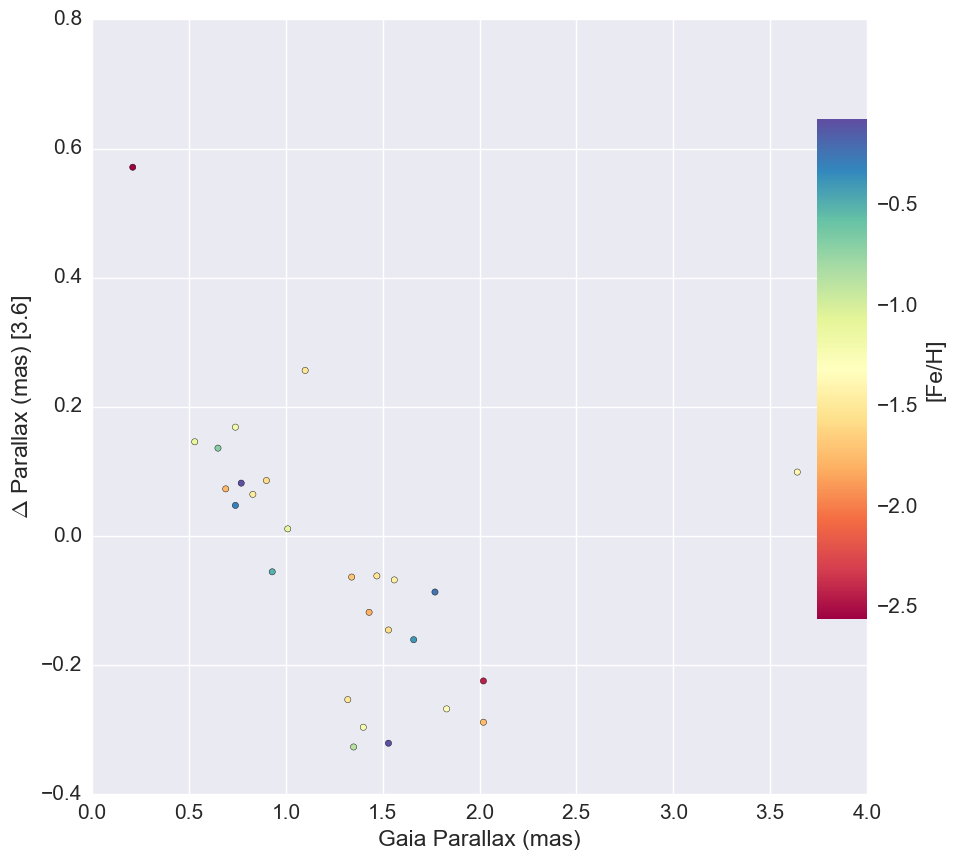

In [49]:
p1 = np.arange(0, 4, 0.01)
fig = mp.figure(figsize=(10,10))

axp1 = mp.subplot(111)



delta_36 = rrab_gaia_df.varpi_spitzer_3p6 - rrab_gaia_df.Plx

#axp1.plot(p1, p1, 'k-')
im = axp1.scatter(rrab_gaia_df.Plx, delta_36, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)

mp.xlabel('Gaia Parallax (mas)')
mp.ylabel('$\Delta$ Parallax (mas) [3.6]')
mp.plot()
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.5])

cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])

#im.set_clim(169.6,283.)
cb.set_label("[Fe/H]")

#mp.show()

mp.savefig('delta_parallax.pdf')


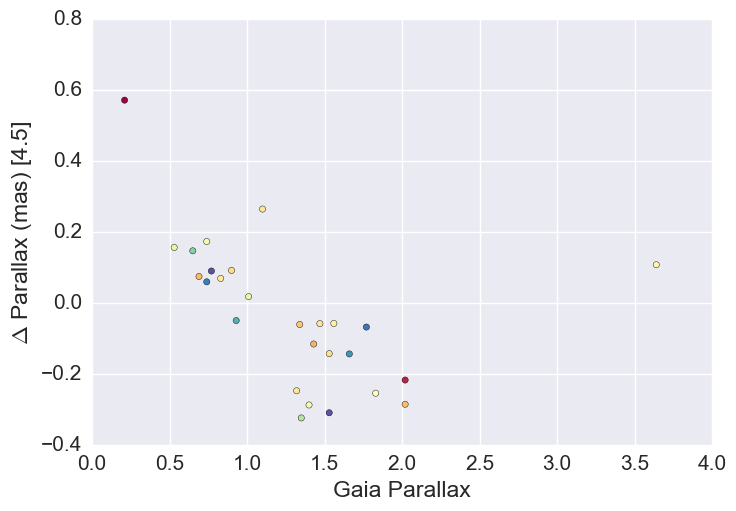

In [50]:
axp1 = mp.subplot(111)
p1 = np.arange(0, 4, 0.01)


delta_45 = rrab_gaia_df.varpi_spitzer_4p5 - rrab_gaia_df.Plx
#axp1.plot(p1, p1, 'k-')
axp1.scatter(rrab_gaia_df.Plx, delta_45, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)

mp.xlabel('Gaia Parallax')
mp.ylabel('$\Delta$ Parallax (mas) [4.5]')
mp.plot()

mp.show()




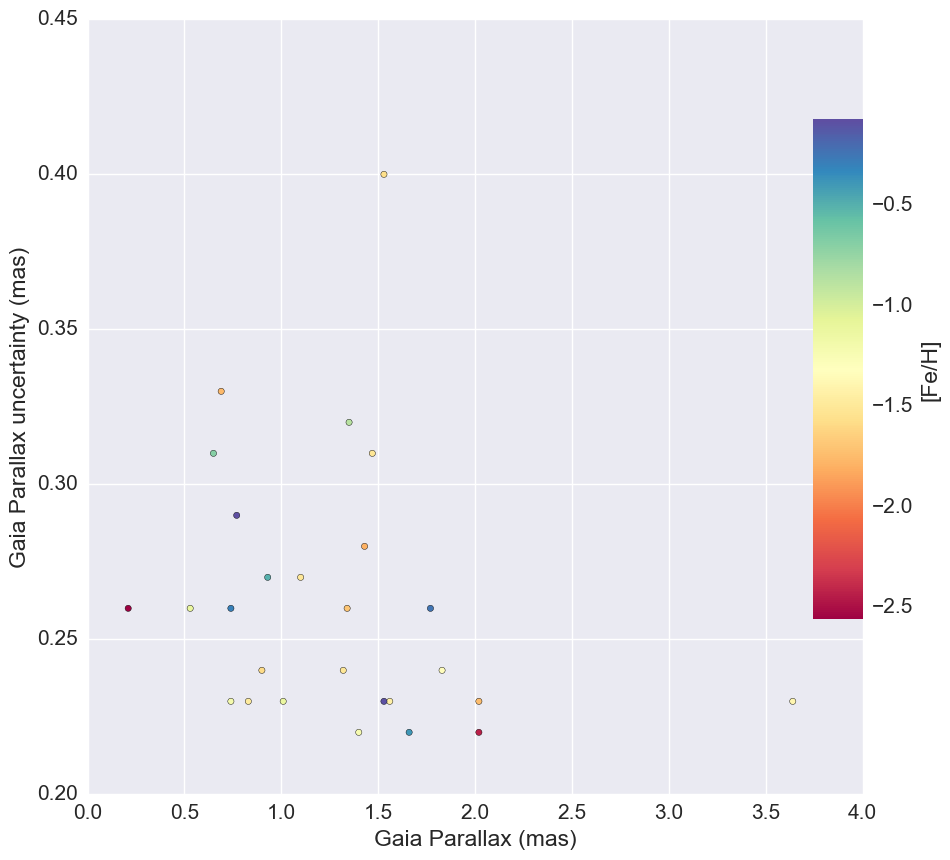

In [51]:

fig = mp.figure(figsize=(10,10))


#axp1.plot(p1, p1, 'k-')
im = mp.scatter(rrab_gaia_df.Plx, rrab_gaia_df.e_Plx, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)

mp.xlabel('Gaia Parallax (mas)')
mp.ylabel('Gaia Parallax uncertainty (mas)')
mp.plot()
cbar_ax = fig.add_axes([0.85, 0.3, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])
#im.set_clim(169.6,283.)
cb.set_label("[Fe/H]")

#mp.show()

mp.savefig('gaia_errors.pdf')





In [52]:
def parallax_to_distance(varpi):
    return 1./(varpi * 10**(-3))

In [53]:
rrab_gaia_df['gaia_distance'] = rrab_gaia_df.apply(lambda x: parallax_to_distance(x.Plx), axis=1)



In [54]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
4       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x      ...        mu_36_derived  mu_45_derived  \
0      RRab -0.24  SW And      ...             8.869258       8.843948   
1      RRab -1.48  WY Ant      ...            10.242144      10.229011   
2      RRab -2.43   X Ari      ...             8.728987       8.719026   
3      RRab -1.76  ST Boo      ...            10.587445      10.580788   
4      RRab -2.56  UY Boo      ...            10.536661      10.534517   
5      RRab -1.44  XZ Cyg      ...             9.131147       9.115010   
6      RRab -0.39  DX Del      ...             9.120330       9.094582   
7      RRab -1.80  SU Dra      ...             9.410619       9.404936   
8      RRab -1.12  SW Dra      ...             9.954710       9.938480   
9      RRab -1.33  RX Eri      ...             9.031187       9.011108   
10     RRab -1.70  SV Eri      ...             9.470052       9.463510   
11     RRab -0.29  RR Gem      ...            10.519040      10.483686   
12     RRab -0.69  TW Her      ...            10.522737      10.491023   
13     RRab -1.58  VX Her      ...            10.030727      10.016380   
14     RRab -1.50  SV Hya      ...             9.859874       9.845753   
15     RRab -1.50   V Ind      ...             9.338123       9.324017   
16     RRab -1.56  TT Lyn      ...             9.293592       9.287852   
17     RRab -1.39  RR Lyr      ...             7.136231       7.130746   
18     RRab -1.74  UV Oct      ...             8.807694       8.802806   
19     RRab -0.08  AV Peg      ...             9.587610       9.565194   
20     RRab -1.22  BH Peg      ...             9.785390       9.766380   
21     RRab -1.11  HK Pup      ...            10.850617      10.815010   
22     RRab -0.07  AN Ser      ...            10.348114      10.325577   
23     RRab -0.49  AB UMa      ...            10.291050      10.274355   
24     RRab -1.20  RV UMa      ...            10.208

# Distance comparison plots:


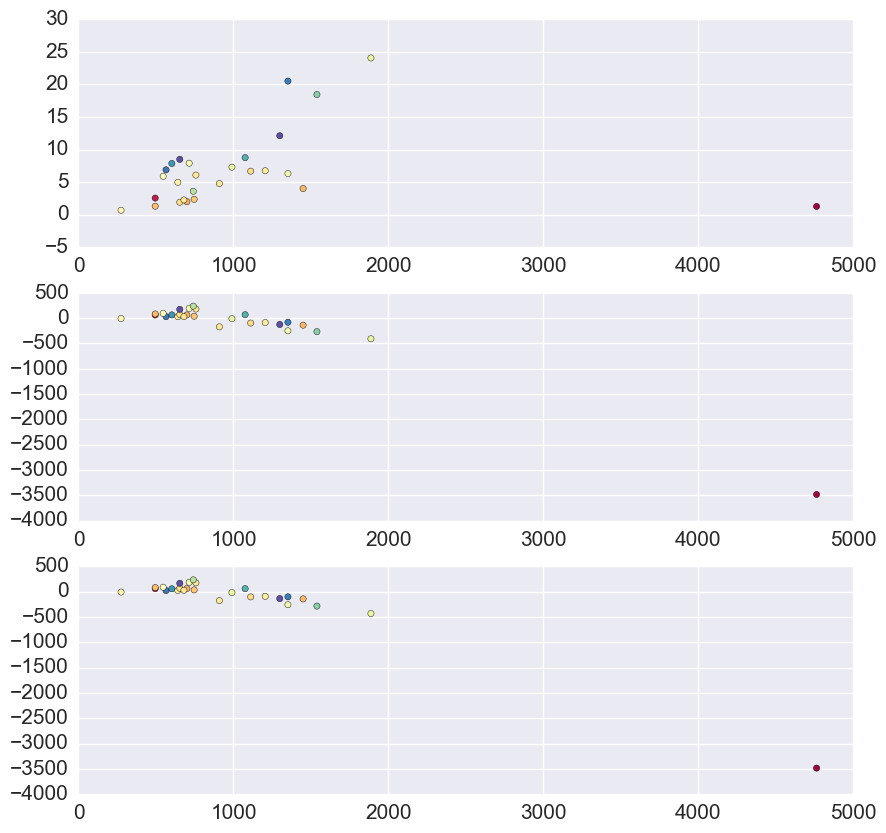

In [55]:
fig = mp.figure(figsize=(10,10))

axp1 = mp.subplot(311)
axp2 = mp.subplot(312)
axp3 = mp.subplot(313)



### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance

im = axp1.scatter(rrab_gaia_df.gaia_distance, delta_spitzer, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)
axp2.scatter(rrab_gaia_df.gaia_distance, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)
axp3.scatter(rrab_gaia_df.gaia_distance, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral)



### Gaia distance to UY Boo is wrong
* Gaia parallax = 0.21 mas -> d = 4760 pc
* Hipparcos = 1.0 mas -> 1000 pc
* Feast et al. 2008 = 1.45 mas -> 689 pc
* Spitzer conversion = 1280 pc

Removing UY Boo from analysis

In [56]:
rrab_gaia_df = rrab_gaia_df[rrab_gaia_df.Name_lower != 'uyboo']

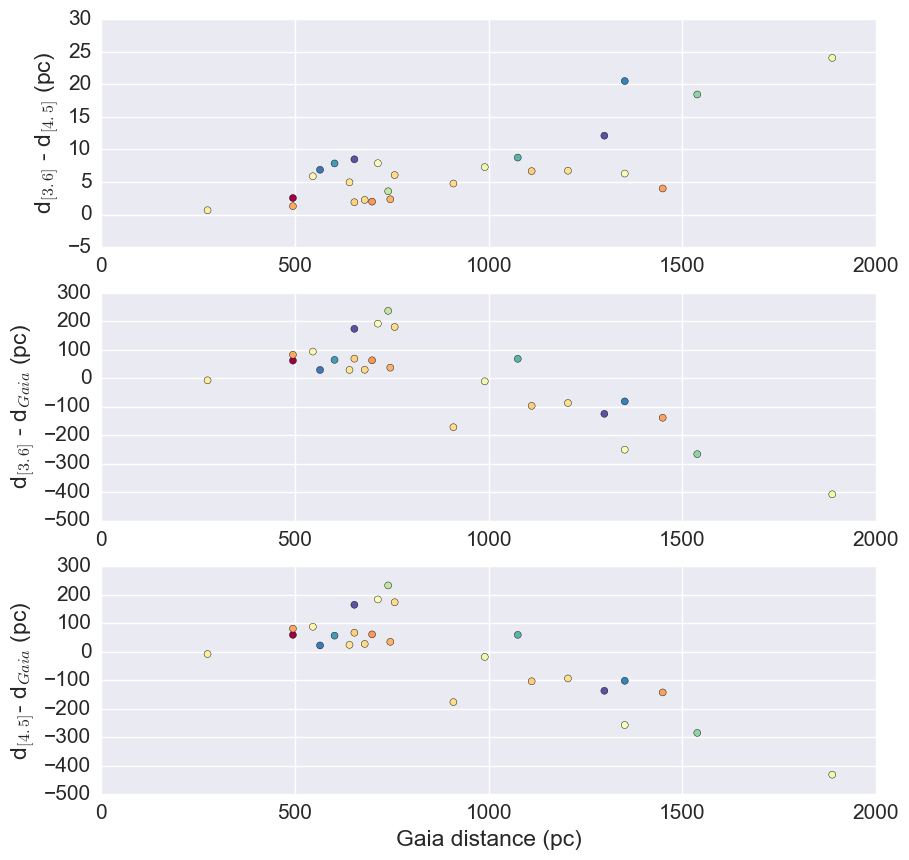

In [57]:
fig = mp.figure(figsize=(10,10))

axp1 = mp.subplot(311)
axp2 = mp.subplot(312)
axp3 = mp.subplot(313)



### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance

im = axp1.scatter(rrab_gaia_df.gaia_distance, delta_spitzer, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=25)
axp1.set_ylabel('d$_{[3.6]}$ - d$_{[4.5]}$ (pc)')
axp2.scatter(rrab_gaia_df.gaia_distance, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=25)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp3.scatter(rrab_gaia_df.gaia_distance, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=25)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')

mp.xlabel('Gaia distance (pc)')



Errors on distance in Spitzer measurements:

$$ \delta d = \dfrac{10^{\left(\frac{\mu + 5}{5}\right)}}{5} \ln 10 \delta \mu$$

$\delta \mu$ given earlier

(differentiation with logs...)

In [58]:
def abs_mag_unc(sigma_a, sigma_b, sigma_c, logp, feh, sigma_feh, b):
    var = (sigma_a**2)*(logp**2) + (sigma_b**2)*(feh**2) + (sigma_c)**2 + (b**2)*(sigma_feh**2)
    std = np.sqrt(var)
    return(std)

In [59]:
# Assumptions:

### Uncertainty on metallicity: 0.15 dex - Fernley - cited in Monson 2017

sigma_a_3p6 = 0.140
sigma_a_4p5 = 0.165

sigma_b_3p6 = e_feh_36
sigma_b_4p5 = e_feh_45

sigma_c_3p6 = e_zp_36
sigma_c_4p5 = e_zp_45

b_3p6 = feh_36
b_4p5 = feh_45


rrab_gaia_df['err_abs_3p6'] = rrab_gaia_df.apply(lambda x: abs_mag_unc(sigma_a_3p6, sigma_b_3p6, sigma_c_3p6, x.logP, x.Fe_H, 0.15, b_3p6), axis=1)
rrab_gaia_df['err_abs_4p5'] = rrab_gaia_df.apply(lambda x: abs_mag_unc(sigma_a_4p5, sigma_b_4p5, sigma_c_4p5, x.logP, x.Fe_H, 0.15, b_4p5), axis=1)

rrab_gaia_df['err_mu_3p6'] = rrab_gaia_df.apply(lambda x: np.sqrt(x.err_abs_3p6**2 + x.err_3p6**2 + x.e_A_3p6**2), axis=1)
rrab_gaia_df['err_mu_4p5'] = rrab_gaia_df.apply(lambda x: np.sqrt(x.err_abs_4p5**2 + x.err_4p5**2 + x.e_A_4p5**2), axis=1)

rrab_gaia_df['err_distance_3p6'] = rrab_gaia_df.apply(lambda x: ((x.distance_3p6 / 5.)*np.log(10)*x.err_mu_3p6), axis=1)
rrab_gaia_df['err_distance_4p5'] = rrab_gaia_df.apply(lambda x: ((x.distance_4p5 / 5.)*np.log(10)*x.err_mu_4p5), axis=1)

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [60]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x        ...         distance_4p5  varpi_spitzer_3p6  \
0      RRab -0.24  SW And        ...           587.204909           1.683249   
1      RRab -1.48  WY Ant        ...          1111.225317           0.894481   
2      RRab -2.43   X Ari        ...           554.376966           1.795571   
3      RRab -1.76  ST Boo        ...          1306.645263           0.762976   
5      RRab -1.44  XZ Cyg        ...           665.276292           1.492006   
6      RRab -0.39  DX Del        ...           659.047152           1.499457   
7      RRab -1.80  SU Dra        ...           760.303899           1.311826   
8      RRab -1.12  SW Dra        ...           972.066433           1.021076   
9      RRab -1.33  RX Eri        ...           634.193257           1.562293   
10     RRab -1.70  SV Eri        ...           781.091488           1.276408   
11     RRab -0.29  RR Gem        ...          1249.502588           0.787394   
12     RRab -0.69  TW Her        ...          1253.731765           0.786054   
13     RRab -1.58  VX Her        ...          1007.571997           0.985949   
14     RRab -1.50  SV Hya        ...           931.430903           1.066658   
15     RRab -1.50   V Ind        ...           732.492774           1.356362   
16     RRab -1.56  TT Lyn        ...           720.394610           1.384464   
17     RRab -1.39  RR Lyr        ...           266.777484           3.738986   
18     RRab -1.74  UV Oct        ...           576.183900           1.731654   
19     RRab -0.08  AV Peg        ...           818.537824           1.209144   
20     RRab -1.22  BH Peg        ...           897.999325           1.103880   
21     RRab -1.11  HK Pup        ...          1455.466112           0.675891   
22     RRab -0.07  AN Ser        ...          1161.757374           0.851878   
23     RRab -0.49  AB UMa        ...          1134.673981           0.874561   
24     RRab -1.20  RV UMa        ...          1094.344856

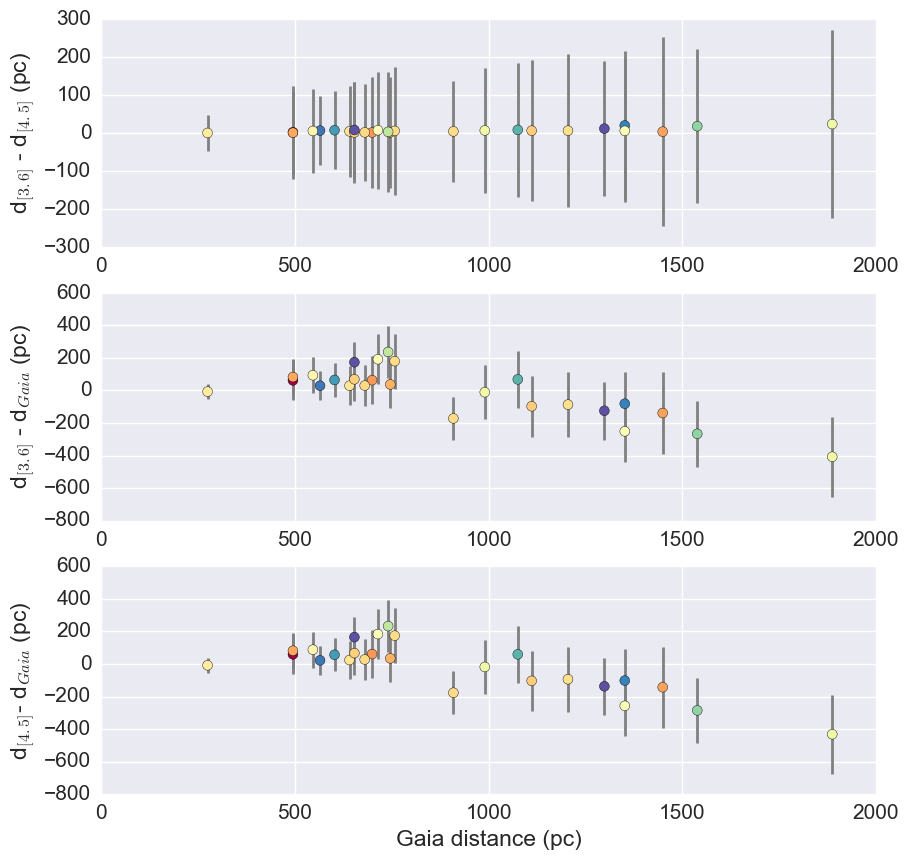

In [61]:
fig = mp.figure(figsize=(10,10))

axp1 = mp.subplot(311)
axp2 = mp.subplot(312)
axp3 = mp.subplot(313)



### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance

axp1.errorbar(rrab_gaia_df.gaia_distance, delta_spitzer, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
im = axp1.scatter(rrab_gaia_df.gaia_distance, delta_spitzer, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp1.set_ylabel('d$_{[3.6]}$ - d$_{[4.5]}$ (pc)')
axp2.errorbar(rrab_gaia_df.gaia_distance, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.gaia_distance, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp3.errorbar(rrab_gaia_df.gaia_distance, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.gaia_distance, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')

mp.xlabel('Gaia distance (pc)')



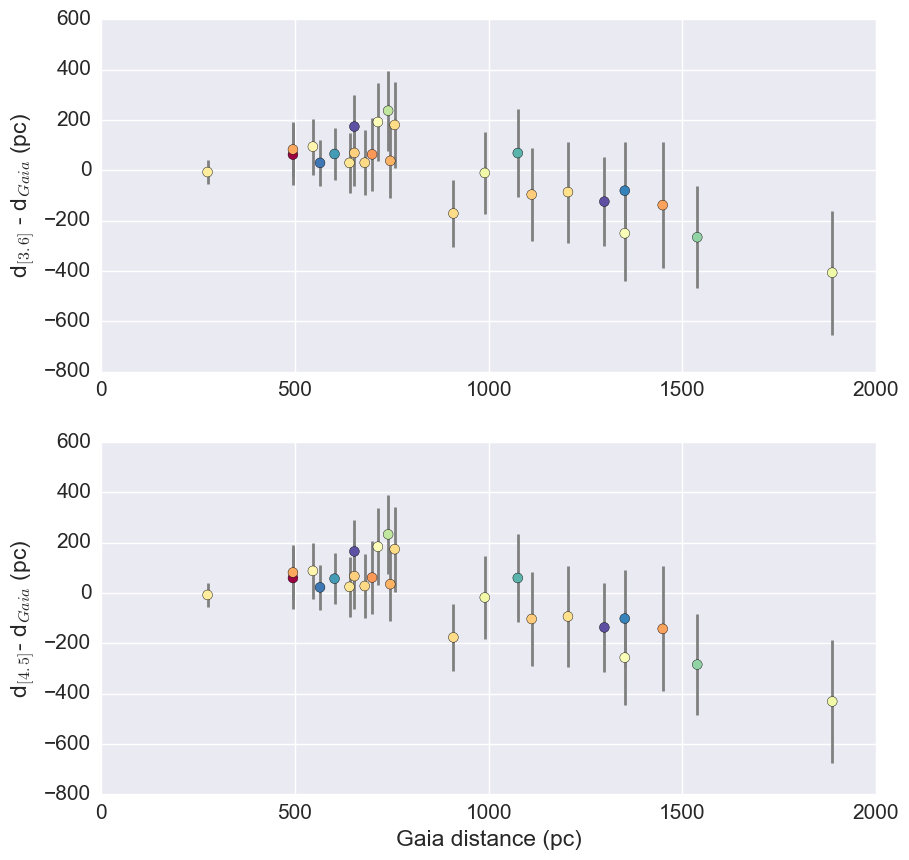

In [62]:
fig = mp.figure(figsize=(10,10))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)



### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance


axp2.errorbar(rrab_gaia_df.gaia_distance, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.gaia_distance, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp3.errorbar(rrab_gaia_df.gaia_distance, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.gaia_distance, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')

mp.xlabel('Gaia distance (pc)')

In [63]:
def distance_dependence(x, a, b, c):
    return a**x + b*x + c

In [64]:
result = curve_fit(distance_dependence, rrab_gaia_df.gaia_distance, delta_s1_gaia)

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [65]:
result

(array([   0.58341216,   -0.30945788,  269.90865172]),
 array([[ inf,  inf,  inf],
        [ inf,  inf,  inf],
        [ inf,  inf,  inf]]))

In [66]:
ax_1 = result[0][0]
bx_1 = result[0][1]
cx_1 = result[0][2]
e_ax1 = result[1][0,0]
e_bx1 = result[1][1,1]
e_cx1 = result[1][2,2]

result = curve_fit(distance_dependence, rrab_gaia_df.gaia_distance, delta_s2_gaia)

ax_2 = result[0][0]
bx_2 = result[0][1]
cx_2 = result[0][2]
e_ax2 = result[1][0,0]
e_bx2 = result[1][1,1]
e_cx2 = result[1][2,2]



/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


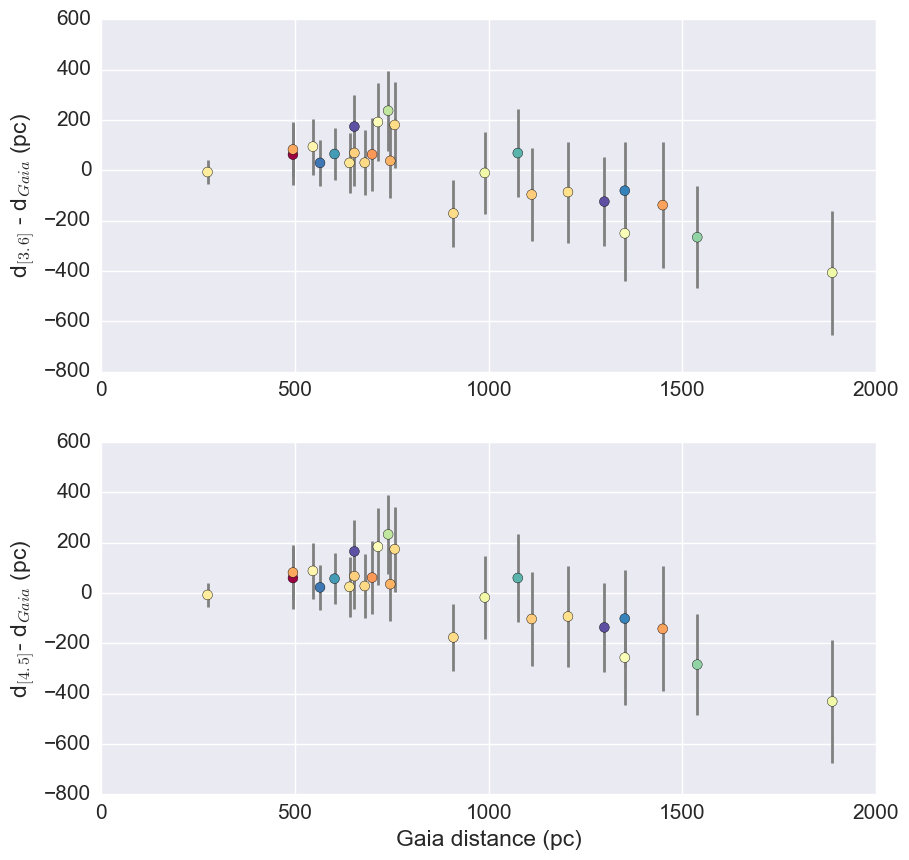

In [67]:
fig = mp.figure(figsize=(10,10))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2000,1)

### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance


axp2.errorbar(rrab_gaia_df.gaia_distance, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.gaia_distance, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')


axp3.errorbar(rrab_gaia_df.gaia_distance, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.gaia_distance, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')
#axp3.plot(p1, ax_2*p1**2 + bx_2*p1 + cx_2, 'k--')


mp.xlabel('Gaia distance (pc)')

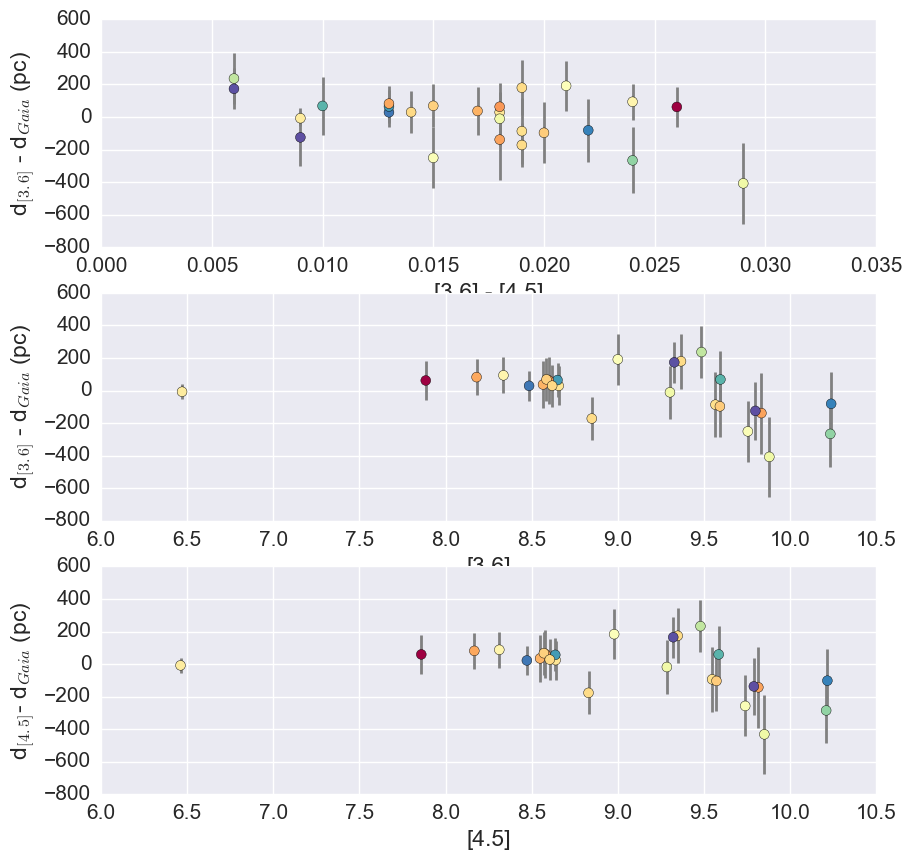

In [68]:
fig = mp.figure(figsize=(10,10))

axp1 = mp.subplot(311)
axp2 = mp.subplot(312)
axp3 = mp.subplot(313)

p1 = np.arange(0,2000,1)

### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance

axp1.errorbar(rrab_gaia_df.mag_3p6 - rrab_gaia_df.mag_4p5, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp1.scatter(rrab_gaia_df.mag_3p6 - rrab_gaia_df.mag_4p5, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp1.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp1.set_xlabel('[3.6] - [4.5]')

axp2.errorbar(rrab_gaia_df.mag_3p6, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.mag_3p6, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp2.set_xlabel('[3.6]')
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')


axp3.errorbar(rrab_gaia_df.mag_4p5, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.mag_4p5, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')
axp3.set_xlabel('[4.5]')


#axp3.plot(p1, ax_2*p1**2 + bx_2*p1 + cx_2, 'k--')




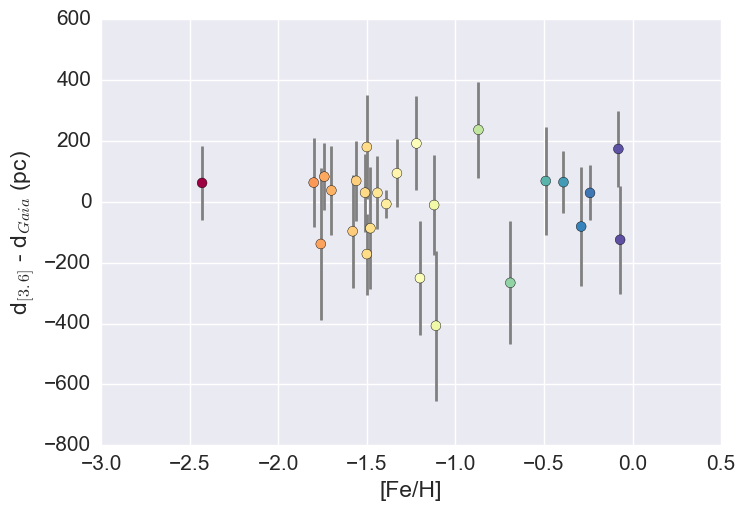

In [69]:
axp1 = mp.subplot(111)
axp1.errorbar(rrab_gaia_df.Fe_H, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp1.scatter(rrab_gaia_df.Fe_H, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp1.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp1.set_xlabel('[Fe/H]')

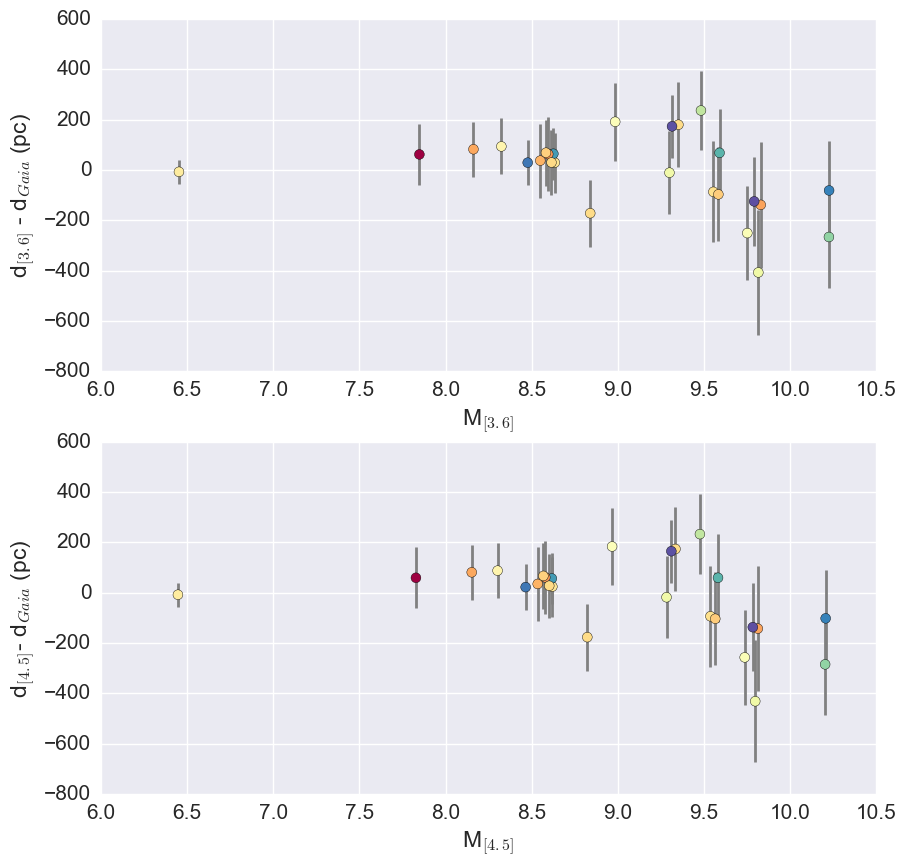

In [70]:
fig = mp.figure(figsize=(10,10))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2000,1)

### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance


axp2.errorbar(rrab_gaia_df.M_abs_3p6, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.M_abs_3p6, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp2.set_xlabel('M$_{[3.6]}$')
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')


axp3.errorbar(rrab_gaia_df.M_abs_4p5, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.M_abs_4p5, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')
axp3.set_xlabel('M$_{[4.5]}$')


#axp3.plot(p1, ax_2*p1**2 + bx_2*p1 + cx_2, 'k--')





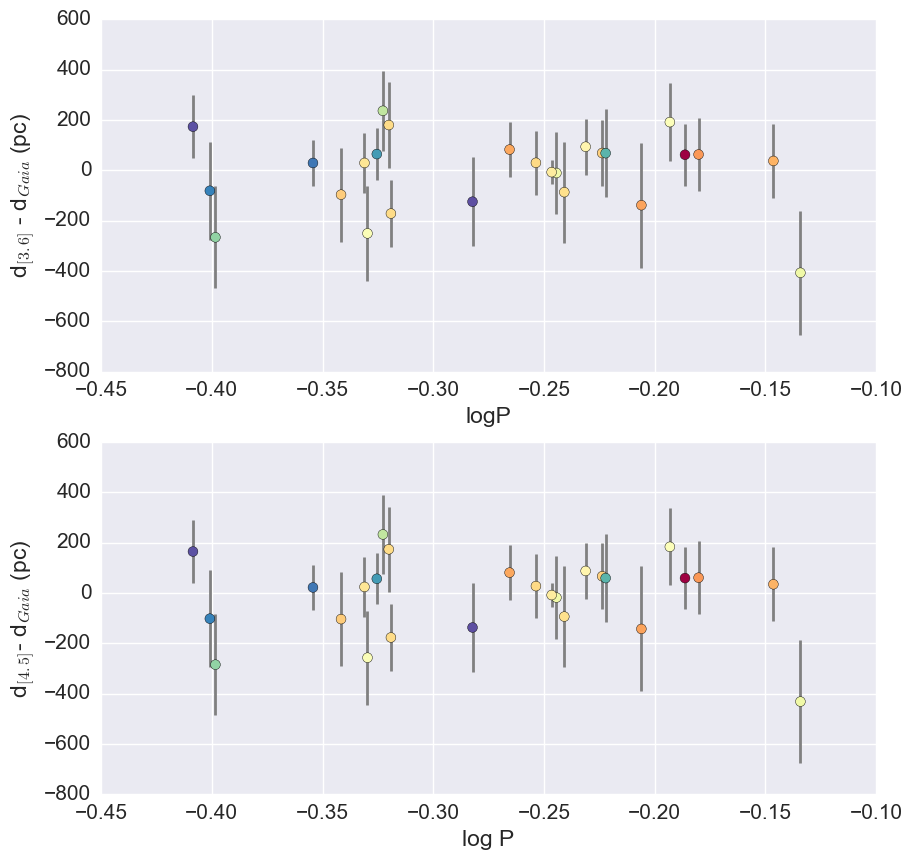

In [71]:
fig = mp.figure(figsize=(10,10))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2000,1)

### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance


axp2.errorbar(rrab_gaia_df.logP, delta_s1_gaia, yerr=rrab_gaia_df.err_distance_3p6, ls='None',zorder=4, color='Grey')
axp2.scatter(rrab_gaia_df.logP, delta_s1_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{[3.6]}$ - d$_{Gaia}$ (pc)')
axp2.set_xlabel('logP')
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')


axp3.errorbar(rrab_gaia_df.logP, delta_s2_gaia, yerr=rrab_gaia_df.err_distance_4p5, ls='None',zorder=4, color='Grey')
axp3.scatter(rrab_gaia_df.logP, delta_s2_gaia, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{[4.5]}$- d$_{Gaia}$ (pc)')
axp3.set_xlabel('log P')

In [72]:
from pandas.tools.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ff56860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115ac7080>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a95bcc0>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b3f6e80>, ...,
       ..., 
        <matplotlib.axes._subplots.AxesSubplot object at 0x134edf240>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x135988a90>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x136978320>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x137638400>]], dtype=object)

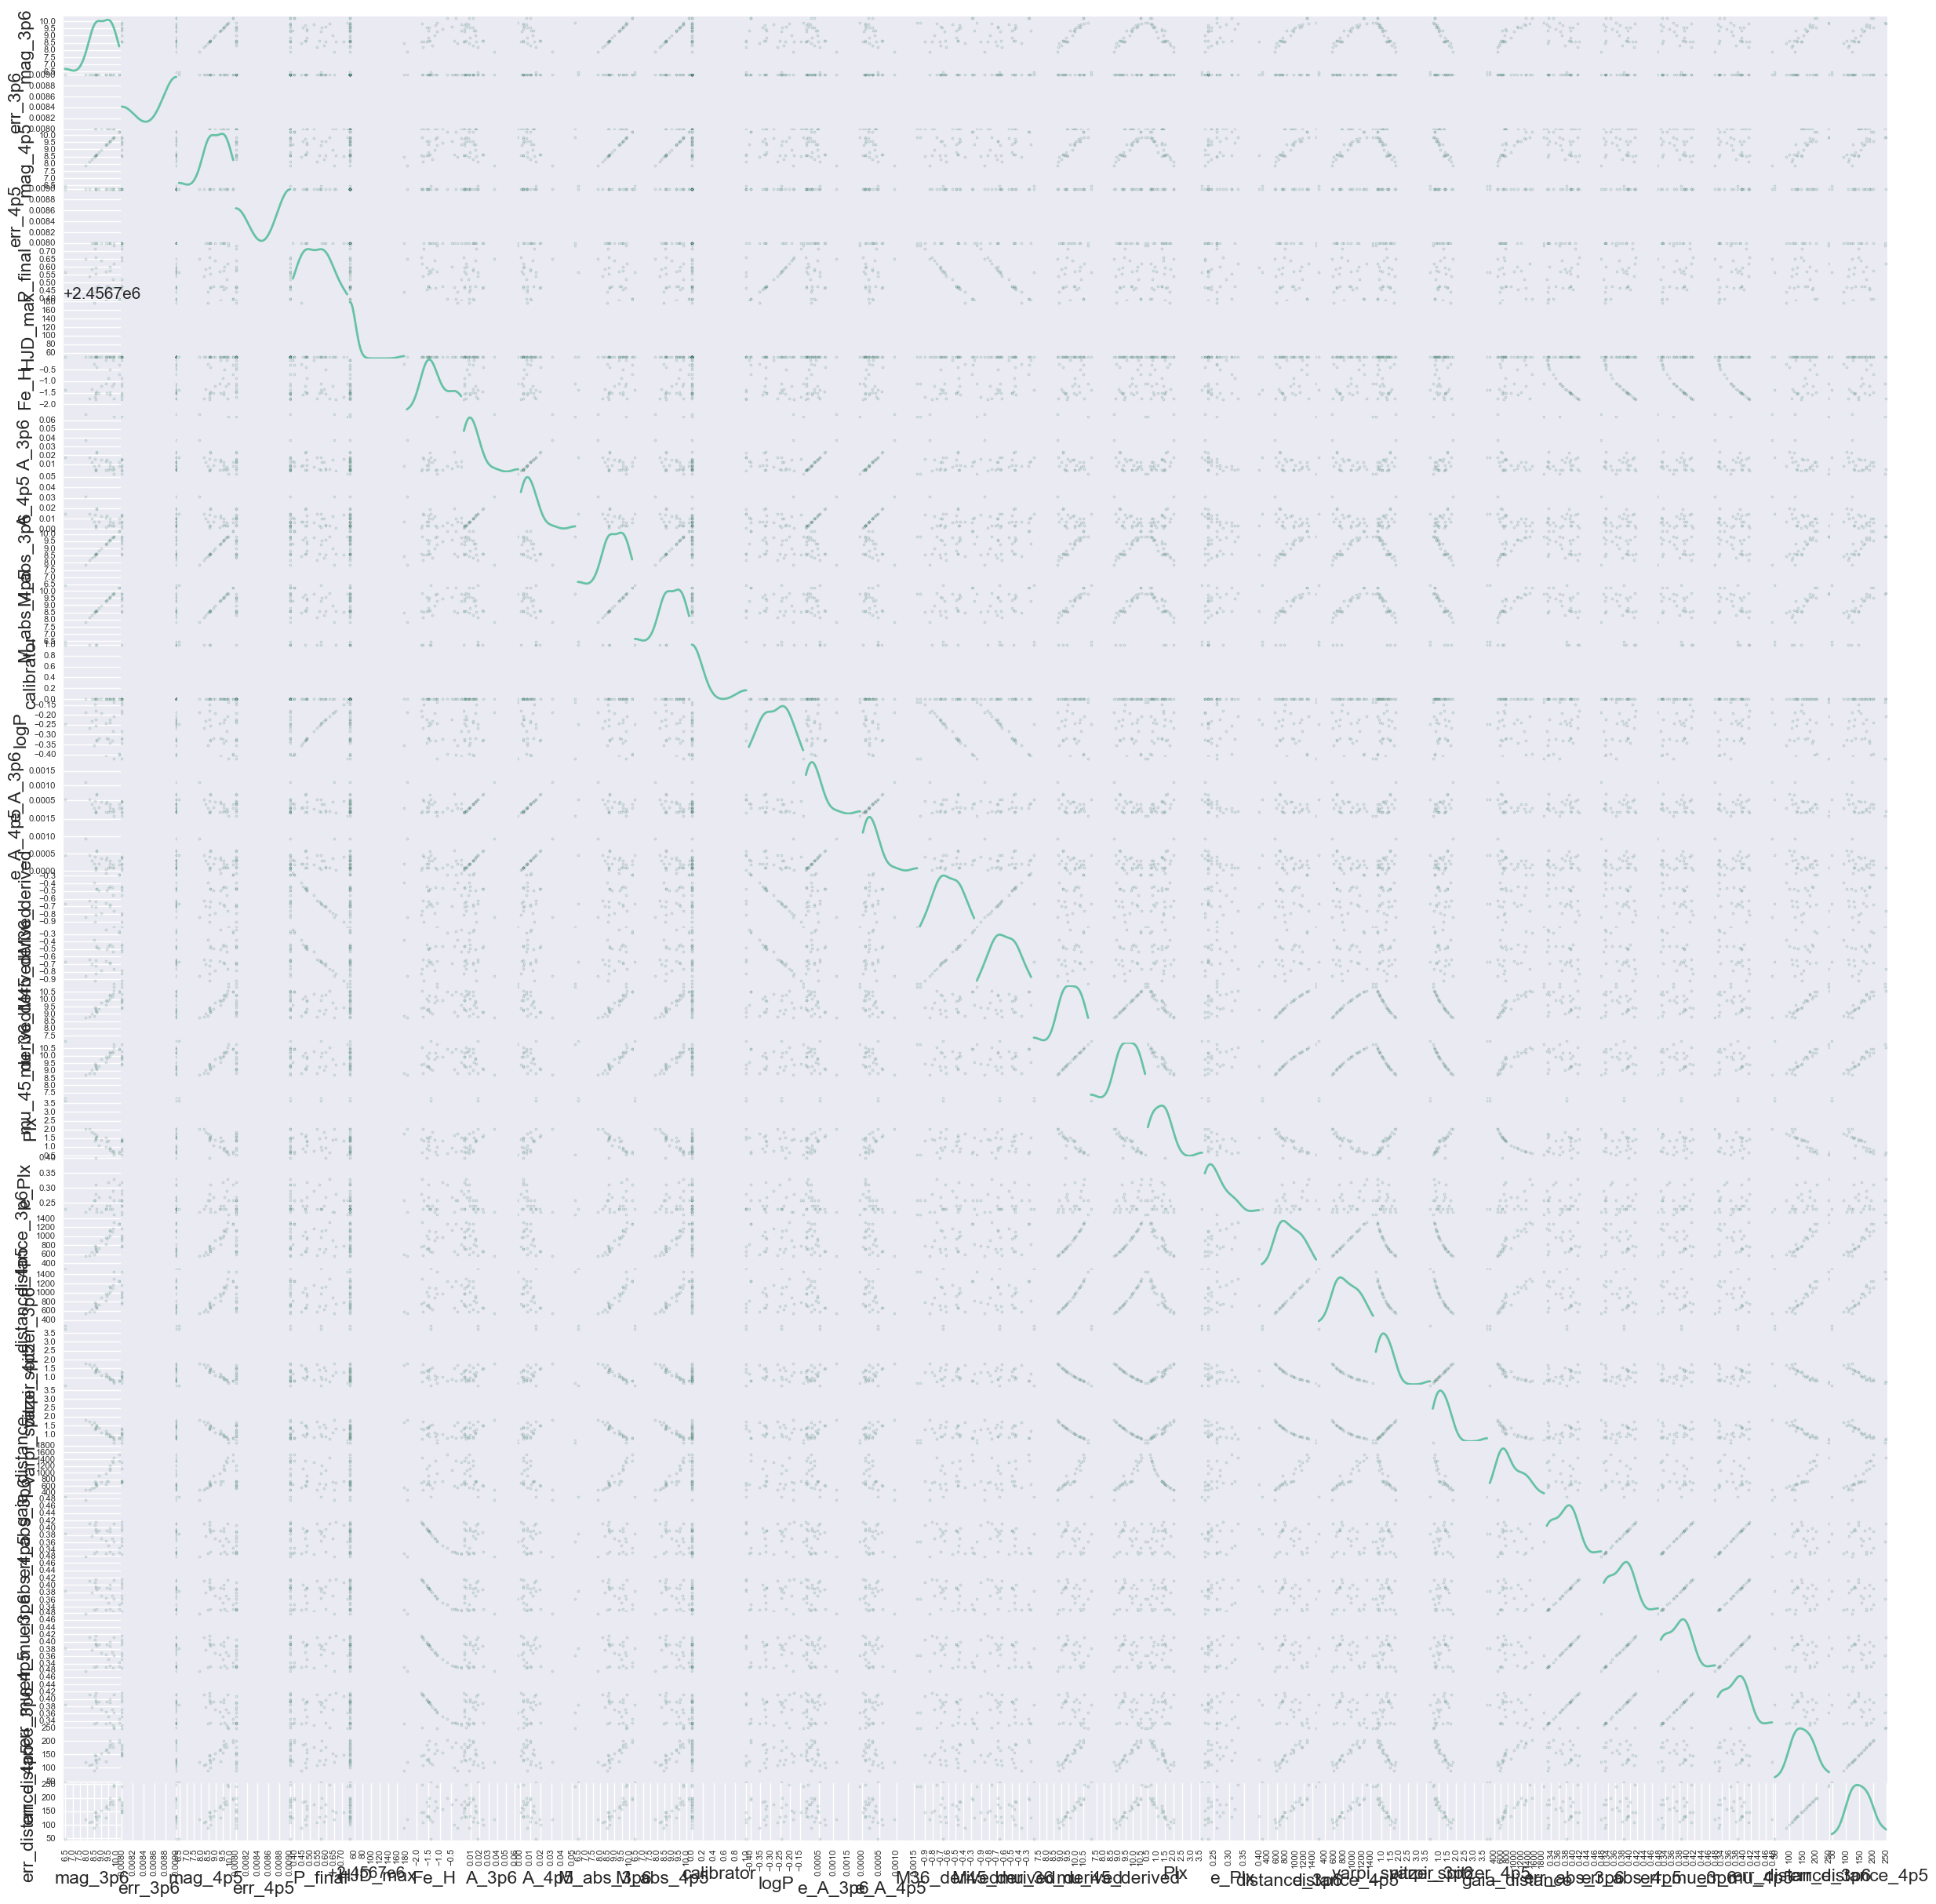

In [73]:
scatter_matrix(rrab_gaia_df, alpha=0.2, figsize=(30,30), diagonal='kde')

In [74]:
rrab_gaia_df.columns


Index(['Name_lower', 'mag_3p6', 'err_3p6', 'mag_4p5', 'err_4p5', 'P_final',
       'HJD_max', 'RRL_type', 'Fe_H', 'Name_x', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'calibrator', 'logP', 'e_A_3p6', 'e_A_4p5', 'M36_derived',
       'M45_derived', 'mu_36_derived', 'mu_45_derived', 'Name_y', 'Plx',
       'e_Plx', 'distance_3p6', 'distance_4p5', 'varpi_spitzer_3p6',
       'varpi_spitzer_4p5', 'gaia_distance', 'err_abs_3p6', 'err_abs_4p5',
       'err_mu_3p6', 'err_mu_4p5', 'err_distance_3p6', 'err_distance_4p5'],
      dtype='object')

In [75]:
plotting_cols = ['Name_lower', 'mag_3p6', 'mag_4p5', 'Fe_H', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'logP', 'Plx', 'distance_3p6', 'distance_4p5', 'gaia_distance']

In [76]:
rrab_plotting = rrab_gaia_df[plotting_cols]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146f8a400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x14b8a7588>]], dtype=object)

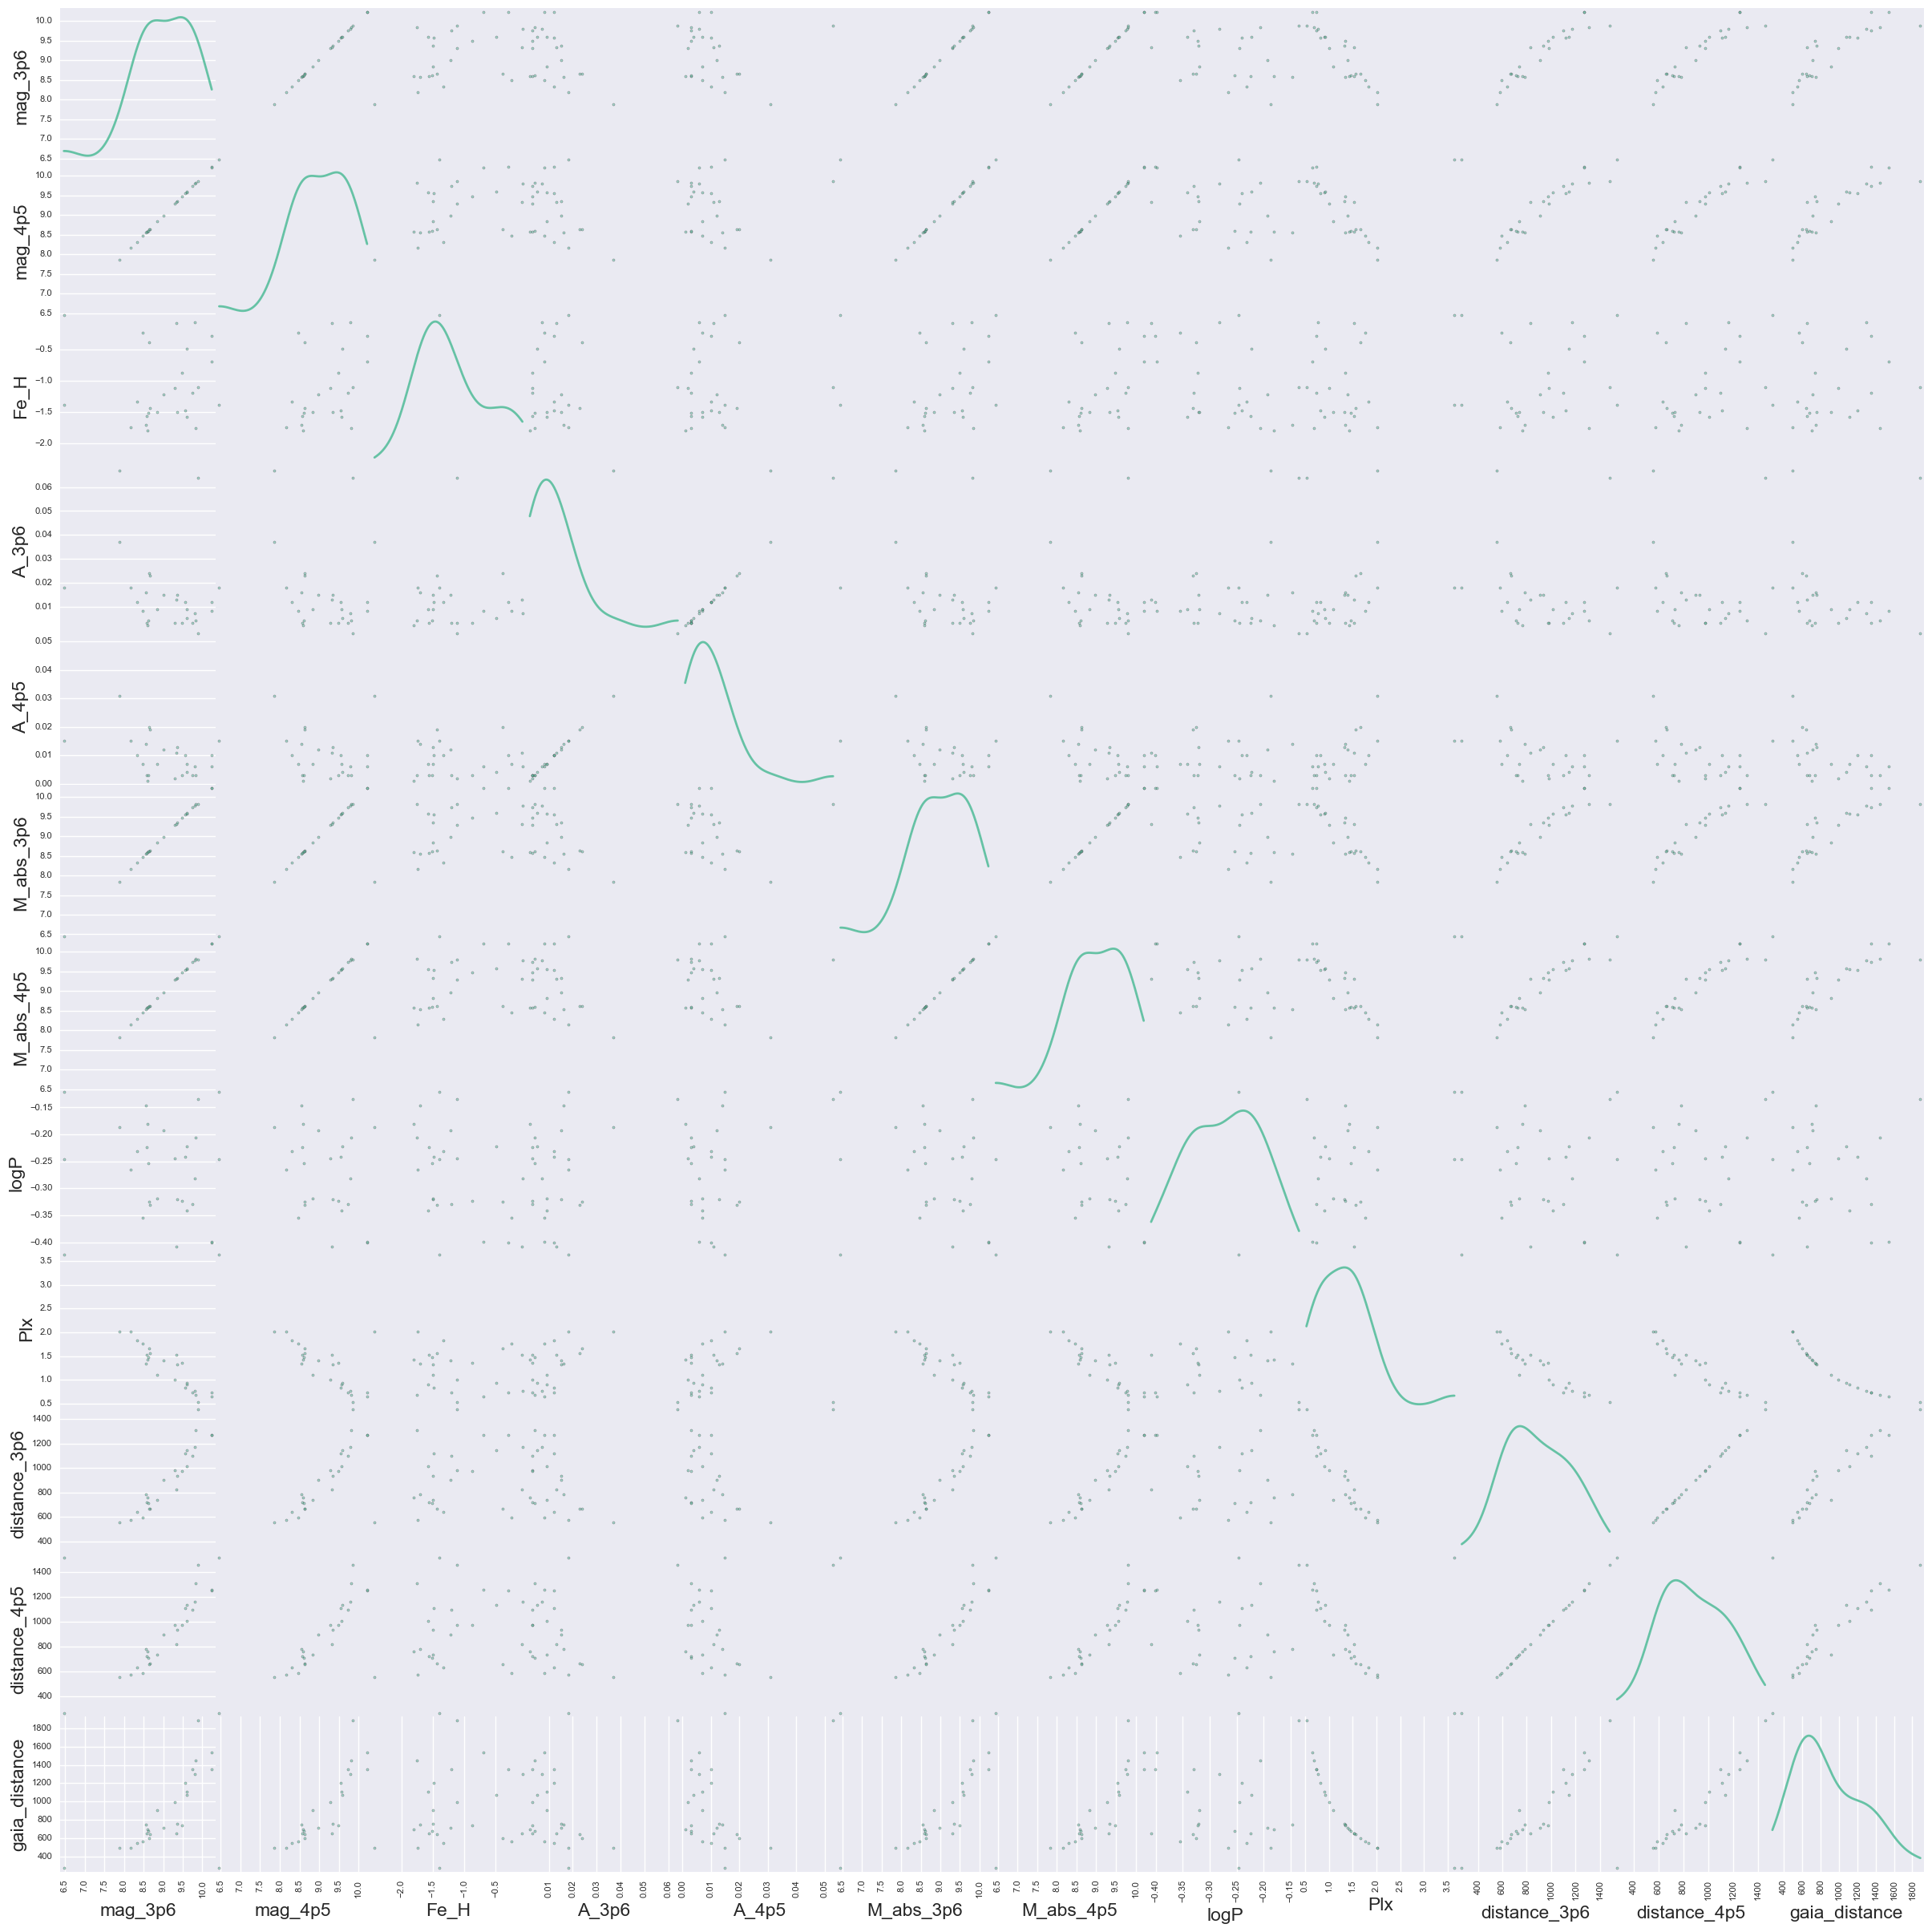

In [77]:
scatter_matrix(rrab_plotting, figsize=(30,30), diagonal='kde')

What about when only the PL is used rather than the PLZ?



In [78]:
## M_36 = -2.342 log P -1.155
## M_45 = -2.358 log P -1.170

rrab_gaia_df['pl_M_3p6'] = rrab_gaia_df.apply(lambda x: (-2.342 * x.logP - 1.155), axis=1)
rrab_gaia_df['pl_M_4p5'] = rrab_gaia_df.apply(lambda x: (-2.358 * x.logP - 1.170), axis=1)

rrab_gaia_df['pl_distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mag_3p6 - x.pl_M_3p6 - x.A_3p6), axis=1)
rrab_gaia_df['pl_distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mag_4p5 - x.pl_M_4p5 - x.A_4p5), axis=1)





/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [79]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x       ...         err_abs_3p6  err_abs_4p5  \
0      RRab -0.24  SW And       ...            0.331017     0.332498   
1      RRab -1.48  WY Ant       ...            0.389604     0.390211   
2      RRab -2.43   X Ari       ...            0.476624     0.476942   
3      RRab -1.76  ST Boo       ...            0.412320     0.412752   
5      RRab -1.44  XZ Cyg       ...            0.387838     0.388953   
6      RRab -0.39  DX Del       ...            0.333343     0.334591   
7      RRab -1.80  SU Dra       ...            0.415596     0.415933   
8      RRab -1.12  SW Dra       ...            0.364302     0.364965   
9      RRab -1.33  RX Eri       ...            0.378282     0.378859   
10     RRab -1.70  SV Eri       ...            0.406642     0.406882   
11     RRab -0.29  RR Gem       ...            0.332871     0.334744   
12     RRab -0.69  TW Her       ...            0.344625     0.346414   
13     RRab -1.58  VX Her       ...            0.398986     0.400139   
14     RRab -1.50  SV Hya       ...            0.392275     0.393308   
15     RRab -1.50   V Ind       ...            0.392260     0.393287   
16     RRab -1.56  TT Lyn       ...            0.395728     0.396249   
17     RRab -1.39  RR Lyr       ...            0.382848     0.383492   
18     RRab -1.74  UV Oct       ...            0.411253     0.411945   
19     RRab -0.08  AV Peg       ...            0.330662     0.332619   
20     RRab -1.22  BH Peg       ...            0.370208     0.370631   
21     RRab -1.11  HK Pup       ...            0.362551     0.362779   
22     RRab -0.07  AN Ser       ...            0.328021     0.328984   
23     RRab -0.49  AB UMa       ...            0.334372     0.334973   
24     RRab -1.20  RV UMa       ...            0.370763     0.371918   
25     RRab -1.51  TU UMa       ...            0.392106     0.392770   
26     RRab -0.87  UU Vir       ...            0.351327     0.352493   

    err_mu_3p6  err_mu_4p5  err_

In [80]:
rrab_gaia_df.columns

Index(['Name_lower', 'mag_3p6', 'err_3p6', 'mag_4p5', 'err_4p5', 'P_final',
       'HJD_max', 'RRL_type', 'Fe_H', 'Name_x', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'calibrator', 'logP', 'e_A_3p6', 'e_A_4p5', 'M36_derived',
       'M45_derived', 'mu_36_derived', 'mu_45_derived', 'Name_y', 'Plx',
       'e_Plx', 'distance_3p6', 'distance_4p5', 'varpi_spitzer_3p6',
       'varpi_spitzer_4p5', 'gaia_distance', 'err_abs_3p6', 'err_abs_4p5',
       'err_mu_3p6', 'err_mu_4p5', 'err_distance_3p6', 'err_distance_4p5',
       'pl_M_3p6', 'pl_M_4p5', 'pl_distance_3p6', 'pl_distance_4p5'],
      dtype='object')

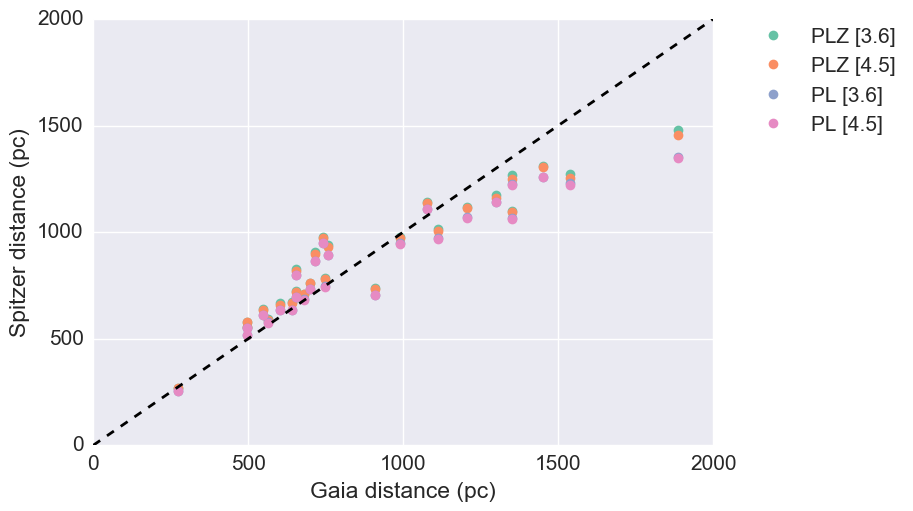

In [81]:
axp1 = mp.subplot(111)

p1 = np.arange(0,2000,1)

axp1.plot(rrab_gaia_df.gaia_distance, rrab_gaia_df.distance_3p6, 'o', ls='None', label='PLZ [3.6]')

axp1.plot(rrab_gaia_df.gaia_distance, rrab_gaia_df.distance_4p5, 'o', ls='None', label='PLZ [4.5]')

axp1.plot(rrab_gaia_df.gaia_distance, rrab_gaia_df.pl_distance_3p6, 'o', ls='None', label='PL [3.6]')

axp1.plot(rrab_gaia_df.gaia_distance, rrab_gaia_df.pl_distance_4p5, 'o', ls='None', label='PL [4.5]')

axp1.plot(p1,p1, 'k--')
mp.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


mp.xlabel('Gaia distance (pc)')
mp.ylabel('Spitzer distance (pc)')


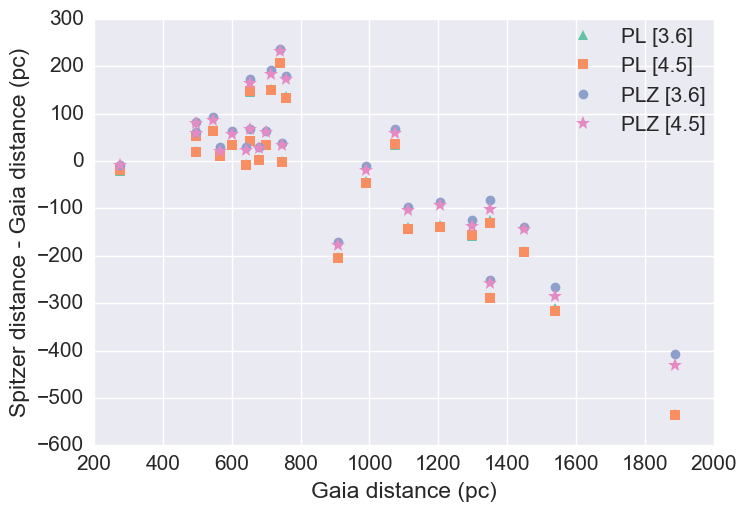

In [82]:
axp1 = mp.subplot(111)

delta_s1_plz = rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_plz = rrab_gaia_df.distance_4p5 - rrab_gaia_df.gaia_distance

delta_s1_pl = rrab_gaia_df.pl_distance_3p6 - rrab_gaia_df.gaia_distance
delta_s2_pl = rrab_gaia_df.pl_distance_4p5 - rrab_gaia_df.gaia_distance

axp1.plot(rrab_gaia_df.gaia_distance, delta_s1_pl, '^', ls='None', label='PL [3.6]')

axp1.plot(rrab_gaia_df.gaia_distance, delta_s2_pl, 's', ls='None', label='PL [4.5]')

axp1.plot(rrab_gaia_df.gaia_distance, delta_s1_plz, 'o', ls='None', label='PLZ [3.6]')

axp1.plot(rrab_gaia_df.gaia_distance, delta_s2_plz, '*', ls='None', label='PLZ [4.5]', ms=10)



mp.legend(loc=1, borderaxespad=0.)


mp.xlabel('Gaia distance (pc)')
mp.ylabel('Spitzer distance - Gaia distance (pc)')

mp.savefig('gaia_vs_spitzer.jpg')

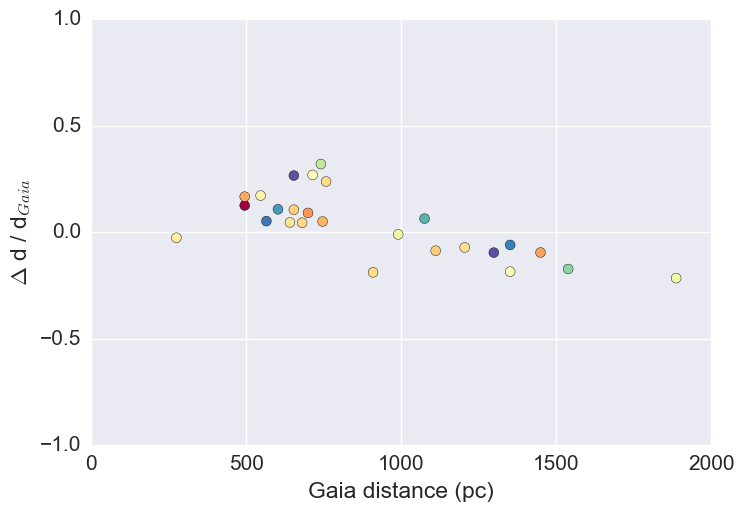

In [83]:
percent_gaia_s1 = (rrab_gaia_df.distance_3p6 - rrab_gaia_df.gaia_distance) / rrab_gaia_df.gaia_distance

axp1 = mp.subplot(111)
myaxis=[0,2000, -1,1]
mp.axis(myaxis)

im = axp1.scatter(rrab_gaia_df.gaia_distance, percent_gaia_s1, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)

axp1.set_xlabel('Gaia distance (pc)')
axp1.set_ylabel('$\Delta$ d / d$_{Gaia}$')

## Correct distances from parallaxes

* Inverting the parallaxes to get distances is the wrong thing to do - See Bailer-Jones (2015), Astraatmadja & Bailer-Jones (2016a, 2016b).

* Within 2kpc, Astraatmadja & Bailer-Jones (2016b) have shown that the MW prior is good.

* Rather than redoing their analysis right now, adopting their catalog distances from Paper III. 

* Using catalog without the TGAS systematic error of 0.3 mas. Adopting this systematic affects the final result for stars that have larger uncertainties and the standard deviation. Will want to eventually rerun the analysis with GKS uncertainties (i.e. reduced TGAS systematics).

In [84]:
tgas_distances_df = pd.read_csv('tgas_dist_all_v01.csv')

In [85]:
len(tgas_distances_df)

2057050

In [86]:
gaia_df.Source

0     1546016668386865792
1     4692528057537147136
2     1191509999055192960
3     1793460110951463424
4     2828497064068310784
5     3972712532526824448
6     4947090013255935616
7     1760981190300823808
8     3030561875047012352
9     6662886601414152448
10     886790590618961536
11    2125982595039626368
12     294072906063827072
13    1317846462066886272
14    1561928422706459264
15    2981136490916347136
16    2211629018927323904
17    1374971554328855424
18    1453674734083793152
19    1058066258521694464
20    5165689383172441216
21    3499611302073156736
22    5022411782439031936
23    2857456207478683776
24    1683444626742055168
25    1565435486842373632
26    1009665138191506432
27    4022618712476736896
28    1492230552420859776
29    4596935588904631040
30    3698723752532514816
31    5768557209320424320
32    3727833391597367424
33    6771307450164337920
34    4467433013440949376
35    6483680156140459904
36    5461994297841116160
37    2142052885197472000
38      1548

In [87]:
tgas_distances_df['3:SourceId']

0                7627862074752
1                9277129363072
2               13297218905216
3               13469017597184
4               15736760328576
5               16527034310784
6               16733192740608
7               16870631694208
8               26834955821312
9               33260226885120
10              44358422235136
11              51745765982848
12              82463372227072
13              83150566993664
14              86105504493056
15              92599494964480
16             111600430360448
17             115723598973952
18             120190364960512
19             122732985598464
20             132662949987200
21             134999412195456
22             139363098967552
23             142730353190144
24             148949465832832
25             180045029052928
26             189871914442624
27             202619377158912
28             219558728443008
29             223407019139328
                  ...         
2057020    6917296790170220032
2057021 

In [90]:
## match the gaia_df to the tgas_distances_df by source id

## renaming column in tgas_distances_df to Source

tgas_distances_df.rename(columns={'3:SourceId':'Source'}, inplace=True)
gaia_distances_df = gaia_df.merge(tgas_distances_df, on='Source')


In [91]:
gaia_distances_df.columns

Index(['Name', 'Period', 'Type', 'id_compare', 'mag_3p6', 'err_3p6', 'amp_3p6',
       'mag_4p5', 'err_4p5', 'amp_4p5', 'rad', 'HIP', 'TYC2', 'SolID',
       'Source', 'RandomI', 'Epoch', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS',
       'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE',
       'RADEcor', 'RAPlxcor', 'RApmRAcor', 'RApmDEcor', 'DEPlxcor',
       'DEpmRAcor', 'DEpmDEcor', 'PlxpmRAcor', 'PlxpmDEcor', 'pmRApmDEcor',
       'NAL', 'NAC', 'NgAL', 'NgAC', 'NbAL', 'NbAC', 'DQ', 'epsi', 'sepsi',
       'APF', 'ARF', 'WAL', 'WAC', 'Apr', 'MatchObs', 'Dup', 'sK1', 'sK2',
       'sK3', 'sK4', 'mK1', 'mK2', 'mK3', 'mK4', 'o_<Gmag>', '<FG>', 'e_<FG>',
       '<Gmag>', 'Var', 'GLON', 'GLAT', 'ELON', 'ELAT', 'A_3p6', 'A_4p5', 'Z',
       'log_P', 'log_P_f', '##1:HIPId', '2:Tycho2Id', '4:lGal[deg]',
       '5:bGal[deg]', '6:varPi[mas]', '7:sigmaVarPi[mas]', '8:GMag[mag]',
       '9:rMo[pc]', '10:r5[pc]', '11:r50[pc]', '12:r95[pc]', '13:sigmaR[pc]',
       '14:rMo[pc]', '15:r5[pc]

In [93]:
gaia_columns = ['Name', 'id_compare', 'Plx', 'e_Plx', '19:rMo[pc]', '20:r5[pc]', '21:r50[pc]', '22:r95[pc]', '23:sigmaR[pc]']
gaia_sel_df = gaia_distances_df[gaia_columns]


In [100]:
gaia_sel_df.rename(columns={'3:SourceId':'Source', '19:rMo[pc]':'rMoMW', '20:r5[pc]':'r5MW', '21:r50[pc]':'r50MW', '22:r95[pc]':'r95MW', '23:sigmaR[pc]':'sigmaRMW'}, inplace=True)
gaia_sel_df.rename(columns={'id_compare':'Name_lower'}, inplace=True)

/Users/vs522/anaconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [101]:
gaia_sel_df

Name Name_lower   Plx  e_Plx        rMoMW         r5MW        r50MW  \
0     ABUma      abuma  0.93   0.27   929.025525   726.004759  1031.333917   
1     AMTuc      amtuc  0.85   0.26  1030.437437   796.040904  1170.275750   
2     ANSer      anser  0.77   0.29  1095.489461   830.724538  1315.268612   
3     AVPeg      avpeg  1.53   0.23   652.190438   542.303595   682.503751   
4     BHPeg      bhpeg  1.40   0.22   701.755982   581.278270   735.758734   
5     BXLeo      bxleo  0.53   0.28  1256.781614   949.198221  1541.200766   
6     CSEri      cseri  2.16   0.23   460.606936   400.385601   470.904467   
7     DXDel      dxdel  1.66   0.22   602.598120   507.505713   625.759226   
8     HKPup      hkpup  0.53   0.26  1681.566882  1153.617031  2027.645129   
9     MTTel      mttel  1.43   0.31   701.070130   553.575425   778.416367   
10    RRGem      rrgem  0.74   0.26   306.768951   232.319125   385.126182   
11    RRLyr      rrlyr  3.64   0.23   275.820401   251.218212   278.161929   
12    RUPsc      rupsc  1.44   0.30   673.475406   538.983228   726.132683   
13    RvCrB      rvcrb  0.50   0.28  1386.593999  1022.842118  1757.828872   
14    RVUma      rvuma  0.74   0.23  1126.501121   876.129199  1268.711065   
15    RXEri      rxeri  1.83   0.24   120.045468   114.776493   120.248041   
16    RZCep      rzcep  1.57   0.24   643.980679   491.962835   771.706792   
17    STBoo      stboo  0.69   0.33  1086.937819   813.286794  1335.132702   
18    STCVn      stcvn  0.22   0.36  1417.526583  1033.932310  2047.054885   
19    SUDra      sudra  1.43   0.28   672.391477   541.342434   719.556190   
20    SVEri      sveri  1.34   0.26   712.757203   576.171510   760.135063   
21    SVHya      svhya  1.32   0.24   738.824701   599.620760   788.098283   
22    SVScl      svscl  0.44   0.32  1250.848753   933.176397  1626.052161   
23    SWAnd      swand  1.77   0.26   561.265936   468.111357   586.382569   
24    SWDra      swdra  1.01   0.23   913.776109   727.900680   989.782313   
25    SXUma      sxuma  0.42   0.34  1244.617481   916.339747  1594.626586   
26    TTLyn      ttlyn  1.53   0.40   620.295122   480.446638   693.869809   
27    TUUma      tuuma  1.47   0.31   645.114035   515.840232   694.711939   
28    TVBoo      tvboo  0.76   0.23  1113.798604   867.157412  1259.780845   
29    TWHer      twher  0.65   0.31  1285.492584   932.924911  1625.581849   
30    UUVir      uuvir  1.35   0.32   328.445175   248.047958   393.969483   
31    UVOct      uvoct  2.02   0.23   496.428645   428.069866   509.521081   
32    UYBoo      uyboo  0.21   0.26  1953.260248  1353.357744  2593.159412   
33  V440Sgr    v440sgr  1.28   0.42   776.576283   585.836810  1012.116861   
34    VXHer      vxher  0.90   0.24  1020.148444   794.822038  1147.798068   
35     VInd       vind  1.10   0.27   613.942313   484.599989   675.644078   
36    WYAnt      wyant  0.83   0.23  1126.422407   870.795367  1276.584118   
37    XZCyg      xzcyg  1.56   0.23   638.813651   533.400259   666.898360   
38     XAri       xari  2.02   0.22   490.464918   424.166464   502.348333   
39    YZCap      yzcap  0.53   0.29  1360.739398   997.836997  1746.098257   

          r95MW     sigmaRMW  
0   1739.868260   308.165198  
1   2138.076140   407.913445  
2   2859.324949   616.595870  
3    918.881670   114.461421  
4    998.050167   126.678388  
5   3380.925818   739.126929  
6    571.421778    51.986680  
7    815.452533    93.600857  
8   4122.297779   902.334574  
9   1318.433367   232.479618  
10   981.120179   227.599105  
11   311.599119    18.352860  
12  1093.444378   168.529225  
13  3990.519621   902.029636  
14  2251.943116   418.180522  
15   126.267853     3.492815  
16  1692.258938   364.831642  
17  3044.672620   678.232774  
18  6784.302596  1747.832914  
19  1055.663753   156.328668  
20  1101.169090   159.573732  
21  1141.928651   164.835225  
22  4178.654943   986.467643  
23   782.548505    95.573601  
24  1514.546812   239.102168  
25

In [102]:
rrab_gaia_df = rrab_df.merge(gaia_sel_df, on='Name_lower')

In [103]:
rrab_gaia_df

Name_lower  mag_3p6  err_3p6  mag_4p5  err_4p5   P_final     HJD_max  \
0       swand    8.485    0.009    8.472    0.008  0.442260  2456877.00   
1       wyant    9.567    0.009    9.548    0.008  0.574346  2456750.50   
2        xari    7.885    0.009    7.859    0.009  0.651173  2456750.50   
3       stboo    9.834    0.009    9.816    0.009  0.622286  2456750.50   
4       uyboo    9.721    0.008    9.696    0.009  0.650830  2456750.50   
5       xzcyg    8.657    0.009    8.639    0.008  0.466599  2456750.50   
6       dxdel    8.650    0.009    8.637    0.008  0.472617  2456750.25   
7       sudra    8.598    0.008    8.580    0.009  0.660420  2456750.50   
8       swdra    9.303    0.009    9.285    0.009  0.569670  2456750.50   
9       rxeri    8.336    0.009    8.312    0.008  0.587246  2456750.50   
10      sveri    8.566    0.008    8.549    0.008  0.713853  2456750.00   
11      rrgem   10.239    0.009   10.217    0.009  0.397290  2456750.50   
12      twher   10.234    0.009   10.210    0.009  0.399600  2456750.50   
13      vxher    9.593    0.008    9.573    0.009  0.455360  2456750.50   
14      svhya    9.367    0.008    9.348    0.009  0.478543  2456750.50   
15       vind    8.849    0.009    8.830    0.009  0.479602  2456750.00   
16      ttlyn    8.586    0.009    8.571    0.009  0.597434  2456750.75   
17      rrlyr    6.470    0.009    6.461    0.009  0.566838  2456750.25   
18      uvoct    8.180    0.009    8.167    0.009  0.542580  2456750.50   
19      avpeg    9.328    0.009    9.322    0.008  0.390375  2456750.50   
20      bhpeg    9.000    0.008    8.979    0.008  0.640993  2456750.75   
21      hkpup    9.880    0.008    9.851    0.008  0.734207  2456750.50   
22      anser    9.799    0.008    9.790    0.009  0.522071  2456750.25   
23      abuma    9.596    0.009    9.586    0.008  0.599581  2456750.75   
24      rvuma    9.755    0.009    9.740    0.009  0.468060  2456750.50   
25      tuuma    8.619    0.009    8.605    0.009  0.557659  2456750.00   
26      uuvir    9.486    0.008    9.480    0.008  0.475609  2456750.00   

   RRL_type  Fe_H  Name_x     ...       mu_36_derived  mu_45_derived  Name_y  \
0      RRab -0.24  SW And     ...            8.869258       8.843948   SWAnd   
1      RRab -1.48  WY Ant     ...           10.242144      10.229011   WYAnt   
2      RRab -2.43   X Ari     ...            8.728987       8.719026    XAri   
3      RRab -1.76  ST Boo     ...           10.587445      10.580788   STBoo   
4      RRab -2.56  UY Boo     ...           10.536661      10.534517   UYBoo   
5      RRab -1.44  XZ Cyg     ...            9.131147       9.115010   XZCyg   
6      RRab -0.39  DX Del     ...            9.120330       9.094582   DXDel   
7      RRab -1.80  SU Dra     ...            9.410619       9.404936   SUDra   
8      RRab -1.12  SW Dra     ...            9.954710       9.938480   SWDra   
9      RRab -1.33  RX Eri     ...            9.031187       9.011108   RXEri   
10     RRab -1.70  SV Eri     ...            9.470052       9.463510   SVEri   
11     RRab -0.29  RR Gem     ...           10.519040      10.483686   RRGem   
12     RRab -0.69  TW Her     ...           10.522737      10.491023   TWHer   
13     RRab -1.58  VX Her     ...           10.030727      10.016380   VXHer   
14     RRab -1.50  SV Hya     ...            9.859874       9.845753   SVHya   
15     RRab -1.50   V Ind     ...            9.338123       9.324017    VInd   
16     RRab -1.56  TT Lyn     ...            9.293592       9.287852   TTLyn   
17     RRab -1.39  RR Lyr     ...            7.136231       7.130746   RRLyr   
18     RRab -1.74  UV Oct     ...            8.807694       8.802806   UVOct   
19     RRab -0.08  AV Peg     ...            9.587610       9.565194   AVPeg   
20     RRab -1.22  BH Peg     ...            9.785390       9.766380   BHPeg   
21     RRab -1.11  HK Pup     ...           10.850617      10.815010   HKPup   
22     RRab -0.07  AN Ser     ...           10.348114      10.

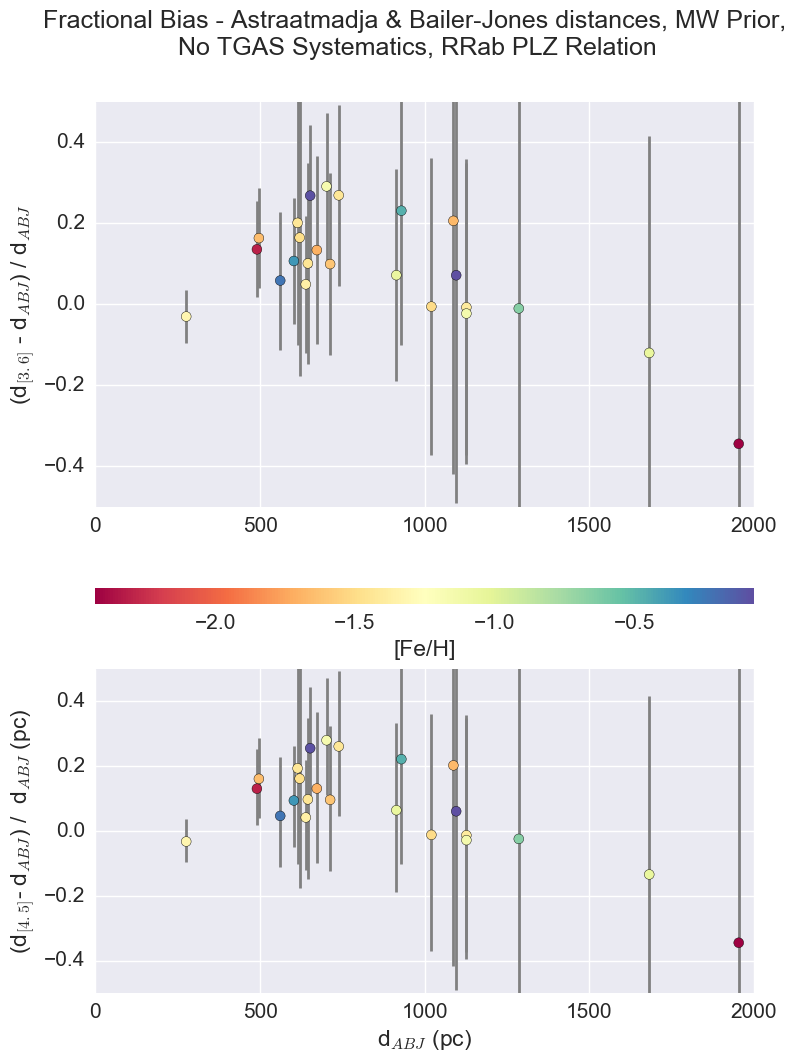

In [129]:
fig = mp.figure(figsize=(8.5, 11.5))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2000,1)

myaxis=[0,2000, -0.5,0.5]
mp.axis(myaxis)

rrab_gaia_df['distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_36_derived), axis=1)
rrab_gaia_df['distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_45_derived), axis=1)


### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.rMoMW
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.rMoMW


### fractional bias

s1_fraction = (rrab_gaia_df.distance_3p6 - rrab_gaia_df.rMoMW) / rrab_gaia_df.rMoMW
s2_fraction = (rrab_gaia_df.distance_4p5 - rrab_gaia_df.rMoMW) / rrab_gaia_df.rMoMW

frac_error = rrab_gaia_df.sigmaRMW / rrab_gaia_df.rMoMW

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(mp.gca())
cax = divider.append_axes("top", "5%", pad="20%")
cb = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])
cb.set_label("[Fe/H]")



axp2.errorbar(rrab_gaia_df.rMoMW, s1_fraction, yerr=frac_error, color='Grey', ls='None')
axp2.scatter(rrab_gaia_df.rMoMW, s1_fraction, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('(d$_{[3.6]}$ - d$_{ABJ}$) / d$_{ABJ}$ ')
#axp2.set_xlabel('d$_{ABJ}$ (pc)')
axp2.axis(myaxis)
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')

axp3.errorbar(rrab_gaia_df.rMoMW, s1_fraction, yerr=frac_error, color='Grey', ls='None')
axp3.scatter(rrab_gaia_df.rMoMW, s2_fraction, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('(d$_{[4.5]}$- d$_{ABJ}$) /  d$_{ABJ}$ (pc)')
axp3.set_xlabel('d$_{ABJ}$ (pc)')

mp.suptitle('Fractional Bias - Astraatmadja & Bailer-Jones distances, MW Prior,\n No TGAS Systematics, RRab PLZ Relation')

#cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.5])

#cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])

#im.set_clim(169.6,283.)


mp.savefig('abj_gaia_pl_bias_zoomed.pdf')


In [105]:
 rrab_gaia_df.columns

Index(['Name_lower', 'mag_3p6', 'err_3p6', 'mag_4p5', 'err_4p5', 'P_final',
       'HJD_max', 'RRL_type', 'Fe_H', 'Name_x', 'A_3p6', 'A_4p5', 'M_abs_3p6',
       'M_abs_4p5', 'calibrator', 'logP', 'e_A_3p6', 'e_A_4p5', 'M36_derived',
       'M45_derived', 'mu_36_derived', 'mu_45_derived', 'Name_y', 'Plx',
       'e_Plx', 'rMoMW', 'r5MW', 'r50MW', 'r95MW', 'sigmaRMW', 'distance_3p6',
       'distance_4p5'],
      dtype='object')

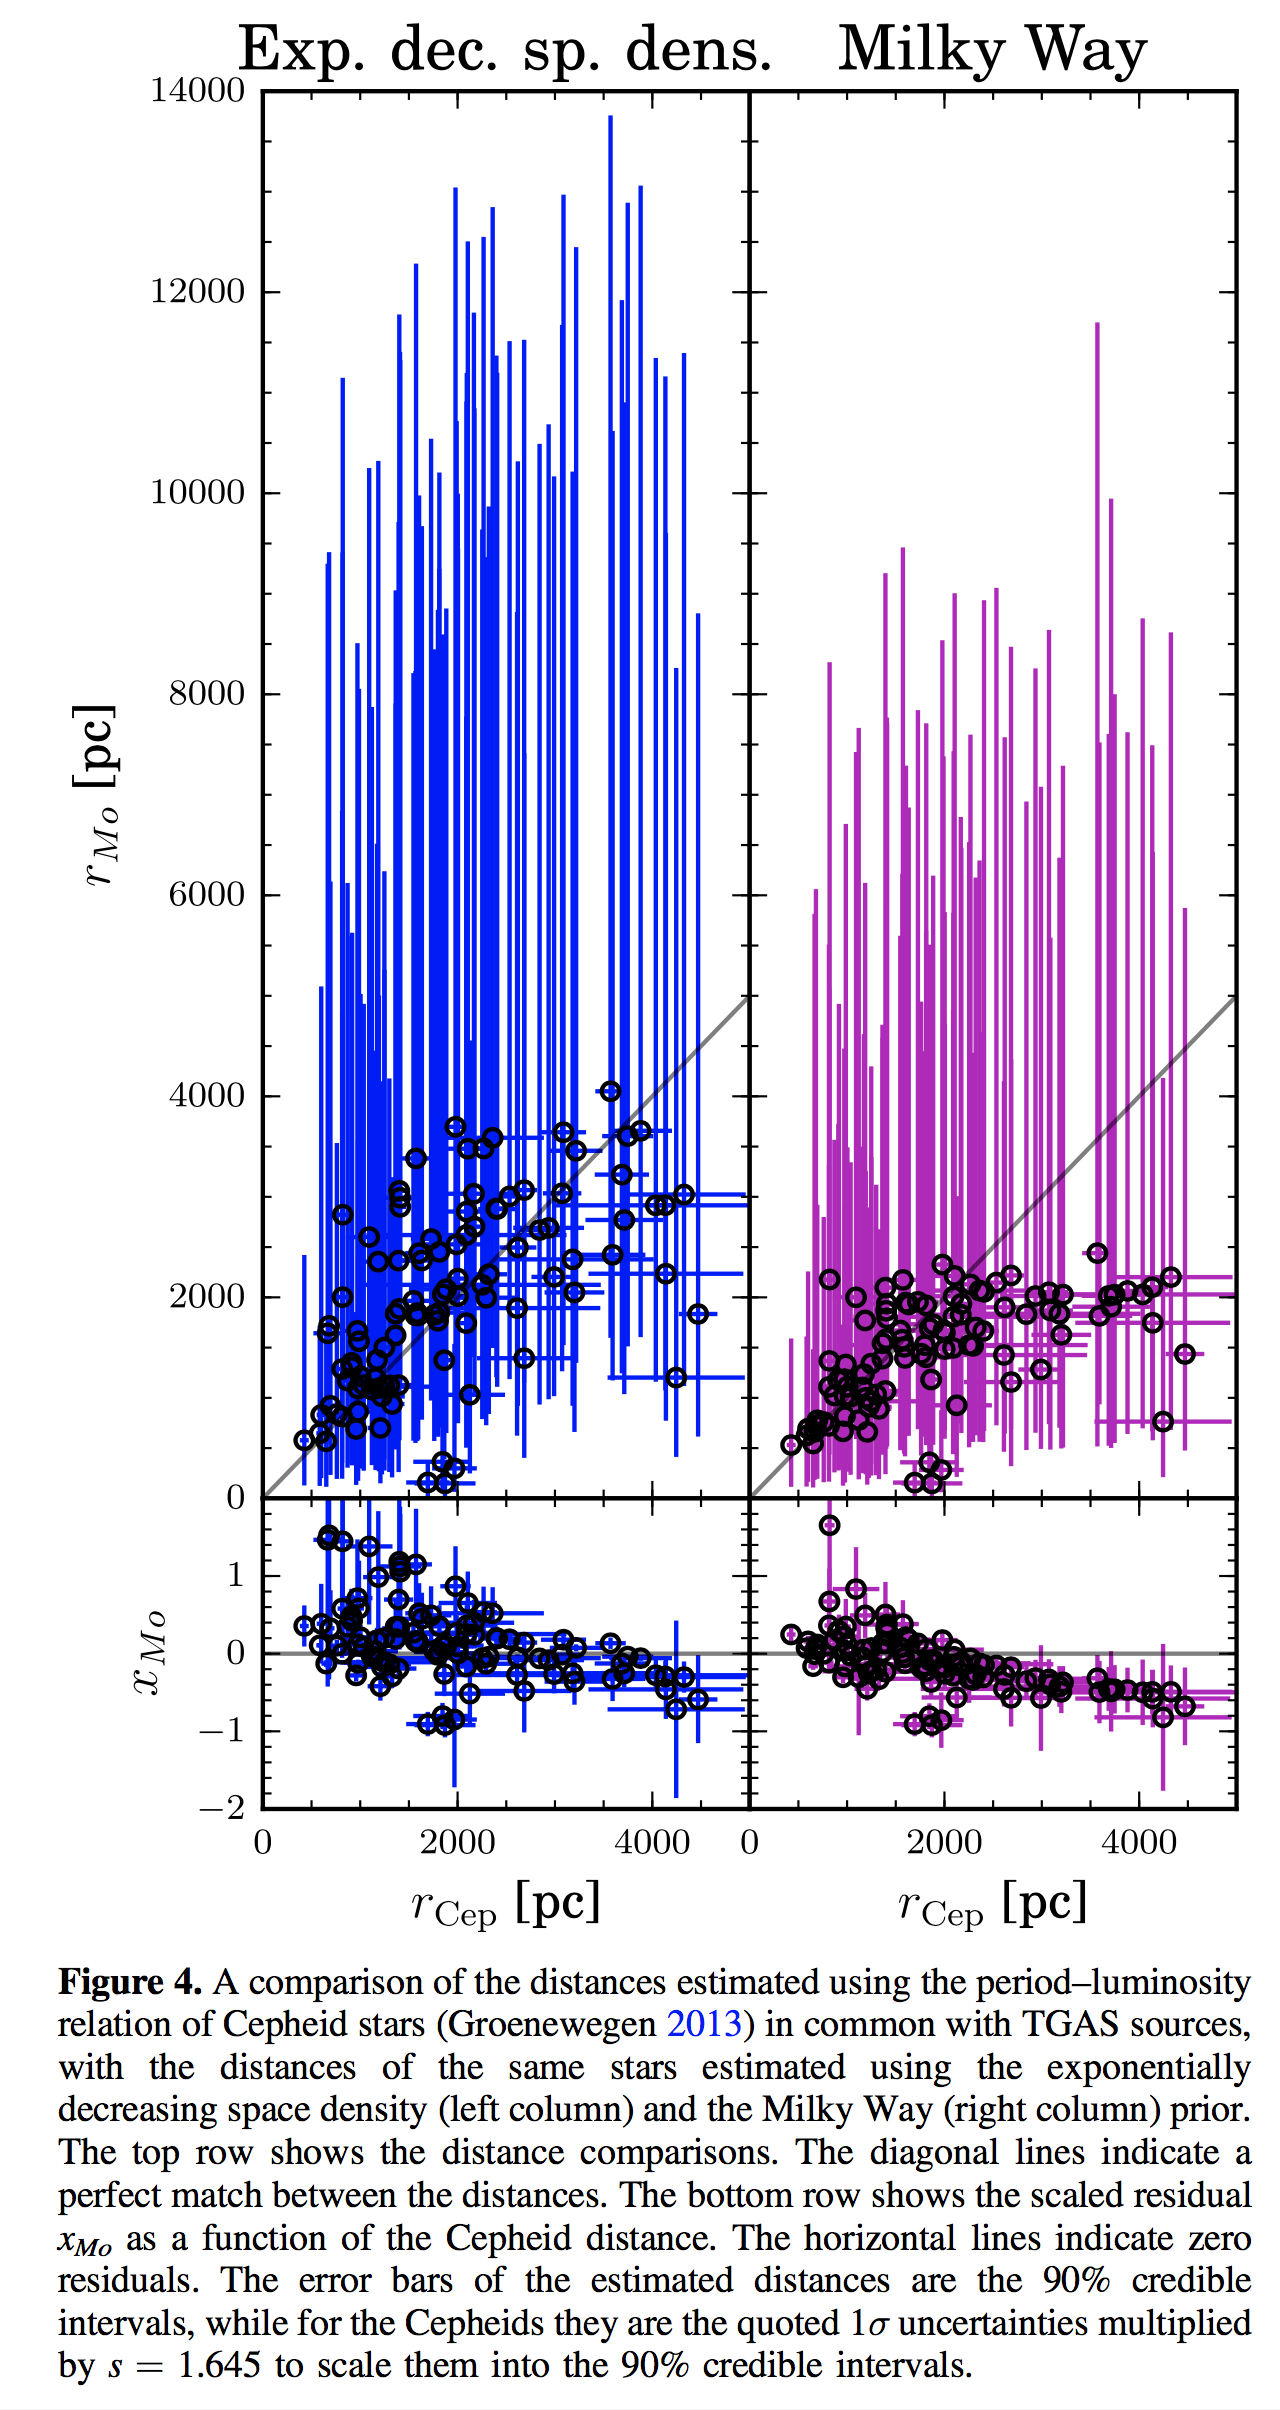

In [133]:
Image("ABJ_paper3_fig4.png")



### Definition of bias $x_{M_{0}} = \dfrac{r_{M_{0}} - r_{Cep}}{r_{Cep}}$, where $r_{Cep}$ is the Hipparcos distance.

In [136]:
ch1_bias = (rrab_gaia_df.distance_3p6 - rrab_gaia_df.rMoMW) / rrab_gaia_df.distance_3p6

ch2_bias = (rrab_gaia_df.distance_4p5 - rrab_gaia_df.rMoMW) / rrab_gaia_df.distance_4p5

In [175]:
average_ch1_bias = np.mean(ch1_bias)
average_ch2_bias = np.mean(ch2_bias)

average_ch1_bias_calibrators = np.mean(ch1_bias[rrab_gaia_df.calibrator==1])
average_ch2_bias_calibrators = np.mean(ch2_bias[rrab_gaia_df.calibrator==1])

print(average_ch1_bias, average_ch1_bias_calibrators, average_ch2_bias, average_ch2_bias_calibrators)

0.137079945564 0.0684735329074 0.131165652386 0.0649819648481


In [143]:
ch1_rms = np.sqrt(np.mean(ch1_bias**2))
ch2_rms = np.sqrt(np.mean(ch2_bias**2))

print(ch1_rms, ch2_rms)

0.292697594541 0.291104433893


In [144]:
ch1_std = np.std(ch1_bias)
ch2_std = np.std(ch2_bias)

print(ch1_std, ch2_std)

0.258613554119 0.259879516443


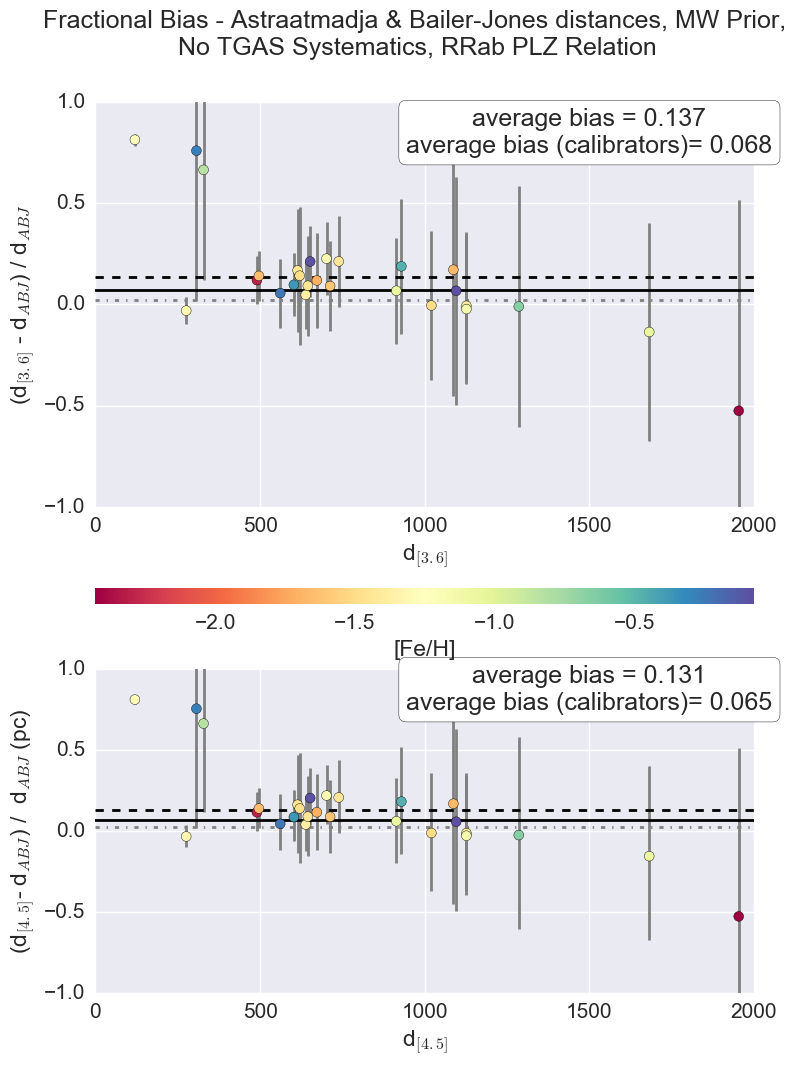

In [176]:
fig = mp.figure(figsize=(8.5, 11.5))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2000,1)

myaxis=[0,2000, -1.0,1.0]
mp.axis(myaxis)

rrab_gaia_df['distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_36_derived), axis=1)
rrab_gaia_df['distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_45_derived), axis=1)


### defining deltas:

delta_spitzer = rrab_gaia_df.distance_3p6 - rrab_gaia_df.distance_4p5
delta_s1_gaia = rrab_gaia_df.distance_3p6 - rrab_gaia_df.rMoMW
delta_s2_gaia = rrab_gaia_df.distance_4p5 - rrab_gaia_df.rMoMW


### fractional bias

s1_fraction = (rrab_gaia_df.distance_3p6 - rrab_gaia_df.rMoMW) / rrab_gaia_df.distance_3p6
s2_fraction = (rrab_gaia_df.distance_4p5 - rrab_gaia_df.rMoMW) / rrab_gaia_df.distance_4p5

frac_error = rrab_gaia_df.sigmaRMW / rrab_gaia_df.rMoMW

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(mp.gca())
cax = divider.append_axes("top", "5%", pad="20%")
cb = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])
cb.set_label("[Fe/H]")



axp2.errorbar(rrab_gaia_df.rMoMW, s1_fraction, yerr=frac_error, color='Grey', ls='None')
axp2.scatter(rrab_gaia_df.rMoMW, s1_fraction, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('(d$_{[3.6]}$ - d$_{ABJ}$) / d$_{ABJ}$ ')
axp2.set_xlabel('d$_{[3.6]}$')
axp2.axhline(y=average_ch1_bias, ls='--', c='k')
axp2.axhline(y=average_ch1_bias_calibrators, ls='-', c='k')

axp2.axhline(y=0.022, ls='-.', c='Grey')
axp2.axis(myaxis)
annotation = 'average bias = ' + str(np.around(average_ch1_bias, decimals=3)) + '\naverage bias (calibrators)= ' + str(np.around(average_ch1_bias_calibrators, decimals=3))
axp2.annotate(annotation, xy=(1500, 0.75), xycoords='data', ha='center', bbox=dict(boxstyle="round", fc="w"))
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')

axp3.errorbar(rrab_gaia_df.rMoMW, s1_fraction, yerr=frac_error, color='Grey', ls='None')
axp3.scatter(rrab_gaia_df.rMoMW, s2_fraction, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('(d$_{[4.5]}$- d$_{ABJ}$) /  d$_{ABJ}$ (pc)')
axp3.set_xlabel('d$_{[4.5]}$')
axp3.axhline(y=average_ch2_bias, ls='--', c='k')
axp3.axhline(y=average_ch2_bias_calibrators, ls='-', c='k')


axp3.axhline(y=0.022, ls='-.', c='Grey')

annotation = 'average bias = ' + str(np.around(average_ch2_bias, decimals=3)) + '\naverage bias (calibrators)= ' + str(np.around(average_ch2_bias_calibrators, decimals=3))
axp3.annotate(annotation, xy=(1500, 0.75), xycoords='data', ha='center', bbox=dict(boxstyle="round", fc="w"))



mp.suptitle('Fractional Bias - Astraatmadja & Bailer-Jones distances, MW Prior,\n No TGAS Systematics, RRab PLZ Relation')

#cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.5])

#cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])

#im.set_clim(169.6,283.)


mp.savefig('abj_gaia_pl_bias_def_changed.pdf')



In [139]:
average_ch1_bias

0.13707994556382744

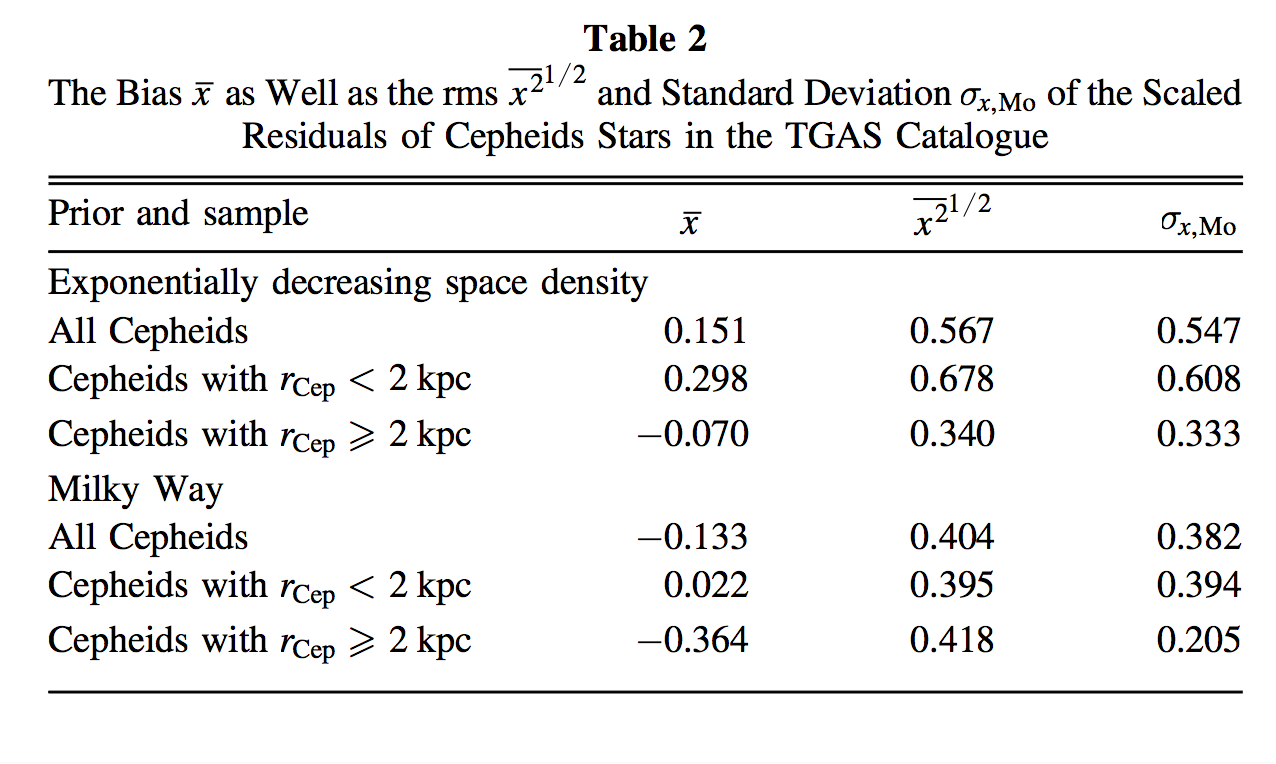

In [142]:
Image('abj_paper3_table2.png')

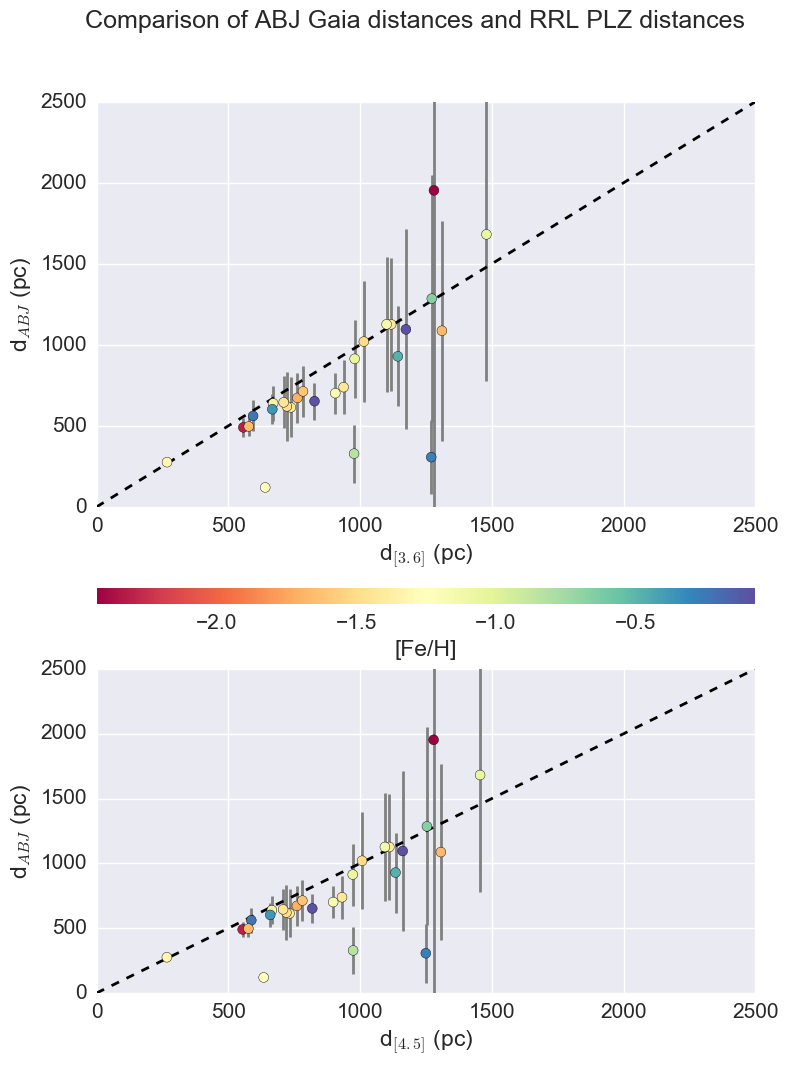

In [155]:
fig = mp.figure(figsize=(8.5, 11.5))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2500,1)

myaxis=[0,2500, 0, 2500]
mp.axis(myaxis)

rrab_gaia_df['distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_36_derived), axis=1)
rrab_gaia_df['distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_45_derived), axis=1)


from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(mp.gca())
cax = divider.append_axes("top", "5%", pad="20%")
cb = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])
cb.set_label("[Fe/H]")



axp2.errorbar(rrab_gaia_df.distance_3p6, rrab_gaia_df.rMoMW, yerr=rrab_gaia_df.sigmaRMW, color='Grey', ls='None')
axp2.scatter(rrab_gaia_df.distance_3p6, rrab_gaia_df.rMoMW, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp2.set_ylabel('d$_{ABJ}$ (pc)')
axp2.set_xlabel('d$_{[3.6]}$ (pc)')
axp2.plot(p1, p1, ls='--', c='k')
axp2.axis(myaxis)
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')

axp3.errorbar(rrab_gaia_df.distance_4p5, rrab_gaia_df.rMoMW, yerr=rrab_gaia_df.sigmaRMW, color='Grey', ls='None')
axp3.scatter(rrab_gaia_df.distance_4p5, rrab_gaia_df.rMoMW, c=rrab_gaia_df['Fe_H'], cmap=mp.cm.Spectral, s=50, zorder=4)
axp3.set_ylabel('d$_{ABJ}$ (pc)')
axp3.set_xlabel('d$_{[4.5]}$ (pc)')
axp3.plot(p1, p1, ls='--', c='k')


mp.suptitle('Comparison of ABJ Gaia distances and RRL PLZ distances')

#cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.5])

#cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])

#im.set_clim(169.6,283.)


mp.savefig('abj_distance_comparison.pdf')




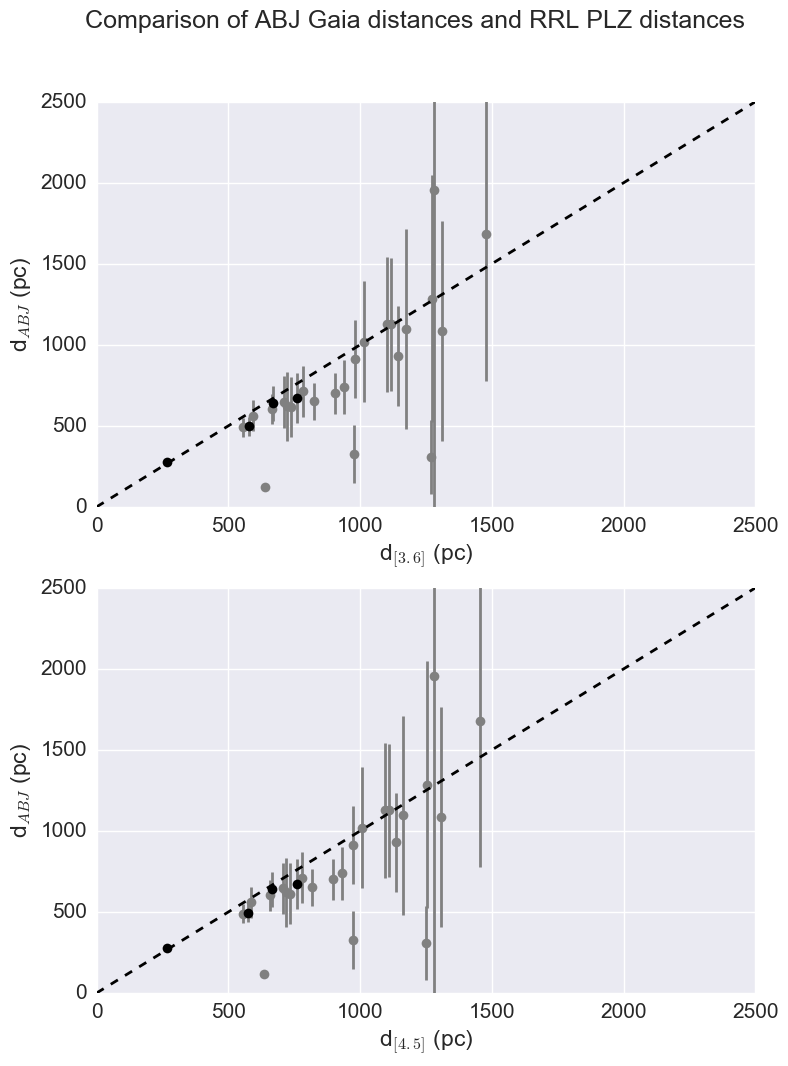

In [166]:
fig = mp.figure(figsize=(8.5, 11.5))

axp2 = mp.subplot(211)
axp3 = mp.subplot(212)

p1 = np.arange(0,2500,1)

myaxis=[0,2500, 0, 2500]
mp.axis(myaxis)

rrab_gaia_df['distance_3p6'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_36_derived), axis=1)
rrab_gaia_df['distance_4p5'] = rrab_gaia_df.apply(lambda x: mu_to_distance(x.mu_45_derived), axis=1)



axp2.errorbar(rrab_gaia_df.distance_3p6[rrab_gaia_df.calibrator==0], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==0], yerr=rrab_gaia_df.sigmaRMW[rrab_gaia_df.calibrator==0], color='Grey', ls='None')
axp2.plot(rrab_gaia_df.distance_3p6[rrab_gaia_df.calibrator==0], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==0], c='Grey', marker='o', ls='None')
axp2.errorbar(rrab_gaia_df.distance_3p6[rrab_gaia_df.calibrator==1], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==1], yerr=rrab_gaia_df.sigmaRMW[rrab_gaia_df.calibrator==1], color='Grey', ls='None')
axp2.plot(rrab_gaia_df.distance_3p6[rrab_gaia_df.calibrator==1], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==1], 'ko', ls='None')




axp2.set_ylabel('d$_{ABJ}$ (pc)')
axp2.set_xlabel('d$_{[3.6]}$ (pc)')
axp2.plot(p1, p1, ls='--', c='k')
axp2.axis(myaxis)
#axp2.plot(p1, ax_1*p1**2 + bx_1*p1 + cx_1, 'k--')
axp3.errorbar(rrab_gaia_df.distance_4p5[rrab_gaia_df.calibrator==0], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==0], yerr=rrab_gaia_df.sigmaRMW[rrab_gaia_df.calibrator==0], color='Grey', ls='None')
axp3.plot(rrab_gaia_df.distance_4p5[rrab_gaia_df.calibrator==0], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==0], c='Grey', marker='o', ls='None')


axp3.errorbar(rrab_gaia_df.distance_4p5[rrab_gaia_df.calibrator==1], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==1], yerr=rrab_gaia_df.sigmaRMW[rrab_gaia_df.calibrator==1], color='Grey', ls='None')
axp3.plot(rrab_gaia_df.distance_4p5[rrab_gaia_df.calibrator==1], rrab_gaia_df.rMoMW[rrab_gaia_df.calibrator==1], 'ko', ls='None')

axp3.set_ylabel('d$_{ABJ}$ (pc)')
axp3.set_xlabel('d$_{[4.5]}$ (pc)')
axp3.plot(p1, p1, ls='--', c='k')


mp.suptitle('Comparison of ABJ Gaia distances and RRL PLZ distances')

#cbar_ax = fig.add_axes([0.95, 0.3, 0.05, 0.5])

#cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', ticks=[-2.5, -2.0, -1.5, -1.0, -0.5, -0.0])

#im.set_clim(169.6,283.)


mp.savefig('abj_distance_comparison.pdf')





In [156]:
rrab_gaia_df.calibrator

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     1.0
6     0.0
7     1.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    1.0
18    1.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
Name: calibrator, dtype: float64

In [179]:
benedict_df = pd.read_csv('benedict_2017_table2.txt', delim_whitespace=True, na_values='cdots')

In [180]:
benedict_df

ID       Name      V  pi_HST  e_HST  pi_Gaia  e_Gaia  pi_Hip  e_hip
0     5      FFAql   5.36    2.81   0.18     1.64    0.89    2.11   0.33
1    12      VYPyx   7.25    6.44   0.23     3.85    0.28    5.01   0.44
2    13      RZCep   9.53    2.12   0.16     2.65    0.24    0.59   1.48
3    14      XZCyg   9.69    1.67   0.17     1.56    0.23    2.29   0.84
4    15      SUDra   9.84    1.42   0.16     1.43    0.28    0.20   1.13
5    16      RRLyr   7.88    3.77   0.13     3.64    0.23    3.46   0.64
6    17      UVOct   9.45    1.71   0.10     2.02    0.23    2.44   0.81
7    20      vA310  10.04   20.13   0.17    21.76    0.41   19.31   1.93
8    21      vA472   9.05   21.70   0.15    20.88    0.24   21.86   1.72
9    22      vA645  11.27   17.46   0.21    22.02    0.25   19.12   5.45
10   25      vA383  12.20   21.53   0.20    20.99    0.36     NaN    NaN
11   28      P3179  10.05    7.45   0.16     8.29    0.88     NaN    NaN
12   55    Feige24  12.65   14.60   0.40    13.06    0.76   10.90   3.94
13   60    V603Aql  11.76    4.01   0.14     2.92    0.54    4.96   2.45
14   62      RRPic  12.11    1.92   0.18     2.45    0.44   -4.63   1.94
15   70      SSCyg  11.64    7.30   0.20     8.56    0.33     NaN    NaN
16  70A      SSCyg  11.64    8.30   0.41     8.56    0.33     NaN    NaN
17   82   HIP87062  10.67    8.94   0.11     8.38    0.86    9.59   2.21
18   83   HIP87788  11.72   10.73   0.13    10.97    0.26   10.01   2.79
19   84   HIP98492  11.47    3.45   0.14     2.48    0.37    9.78   2.77
20   85  HIP103269  10.33   14.12   0.10    13.76    0.22   14.86   1.31
21   92    HD47536   5.26    8.71   0.16     7.95    0.57    8.11   0.23
22   96   HD136118   6.95   19.12   0.22    19.22    0.27   21.47   0.54
23   97    HD33636   6.99   35.60   0.20    33.96    0.82   35.25   1.02
24   98       XO-3   9.86    5.67   0.14     4.96    0.35     NaN    NaN
25   99   HD202206   8.08   22.98   0.13    21.94    0.26   22.06   0.82
26  101   HD132475   8.55   10.18   0.21    10.62    0.24   10.23   0.84
27  102   HD140283   7.21   17.18   0.26    15.96    0.43   17.16   0.68

In [194]:
hst_bias = (benedict_df.pi_HST - benedict_df.pi_Gaia) / benedict_df.pi_HST
hip_bias = (benedict_df.pi_Hip - benedict_df.pi_Gaia) / benedict_df.pi_Hip
hst_hip_bias = (benedict_df.pi_HST - benedict_df.pi_Hip) / benedict_df.pi_HST

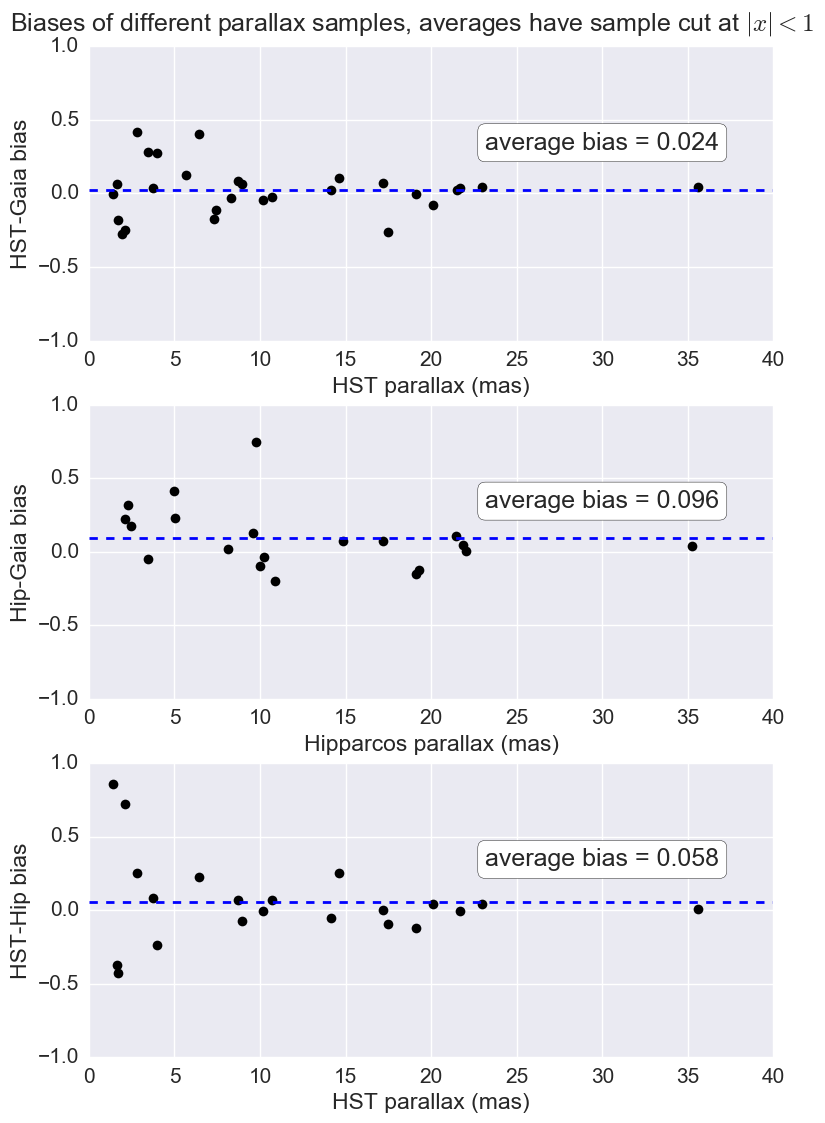

In [219]:
fig = mp.figure(figsize=(8.5, 11.5))



ax1 = mp.subplot(311)
ax2 = mp.subplot(312)
ax3 = mp.subplot(313)


myaxis = [-0,40, -1.0,1.0]
mp.axis(myaxis)

mp.tight_layout(pad=2.0, w_pad=0.5, h_pad=1.0)



ax1.plot(benedict_df.pi_HST, hst_bias, 'ko', ls='None')
ax1.set_ylabel('HST-Gaia bias')
ax1.set_xlabel('HST parallax (mas)')
ax1.axis(myaxis)
mp.suptitle('Biases of different parallax samples, averages have sample cut at $|x|<1$ ')



ax2.plot(benedict_df.pi_Hip, hip_bias, 'ko', ls='None')
ax2.set_ylabel('Hip-Gaia bias')
ax2.set_xlabel('Hipparcos parallax (mas)')
ax2.axis(myaxis)


ax3.plot(benedict_df.pi_HST, hst_hip_bias, 'ko', ls='None')
ax3.set_ylabel('HST-Hip bias')
ax3.set_xlabel('HST parallax (mas)')
ax3.axis(myaxis)


av_hst_gaia = np.mean(hst_bias[(hst_bias > -1.) & (hst_bias <1.)])
av_hip_gaia = np.mean(hip_bias[(hip_bias > -1.) & (hip_bias <1.)])
av_hst_hip = np.mean(hst_hip_bias[(hst_hip_bias > -1.) & (hst_hip_bias <1.)])

ax1.axhline(y=av_hst_gaia, ls='--')
ax2.axhline(y=av_hip_gaia, ls='--')
ax3.axhline(y=av_hst_hip, ls='--')

annotation = 'average bias = ' + str(np.around(av_hst_gaia, decimals=3))
ax1.annotate(annotation, xy=(30, 0.3), xycoords='data', ha='center', bbox=dict(boxstyle="round", fc="w"))

annotation = 'average bias = ' + str(np.around(av_hip_gaia, decimals=3))
ax2.annotate(annotation, xy=(30, 0.3), xycoords='data', ha='center', bbox=dict(boxstyle="round", fc="w"))

annotation = 'average bias = ' + str(np.around(av_hst_hip, decimals=3))
ax3.annotate(annotation, xy=(30, 0.3), xycoords='data', ha='center', bbox=dict(boxstyle="round", fc="w"))





## to do: 

* convert the PLZ distances to inferred parallax - what does that bias look like?
* ERROR BARS